In [1]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [22]:
# %% [markdown]
# # Сравнение Стратегий Работы с Дисбалансом Классов для ddGPredictor
#
# Этот ноутбук воспроизводит эксперимент, аналогичный описанному в статьях А. Дьяконова и оригинальных работах по SMOTE/ADASYN,
# для оценки эффективности различных методов обработки несбалансированных данных на задаче предсказания знака ddG.
# Мы используем библиотеку `imbalanced-learn` (imblearn) для реализации методов сэмплирования.
#
# **Источники:**
# - Блог А. Дьяконова: (Ссылка на блог, если есть, или просто упоминание)
# - Статья SMOTE: Chawla, N. V., et al. "SMOTE: Synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002): 321-357.
# - Статья ADASYN: He, Haibo, et al. "ADASYN: Adaptive synthetic sampling approach for imbalanced learning." 2008 IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence). IEEE, 2008.
# - Документация imblearn: https://imbalanced-learn.org/stable/
#
# **Метрики:**
# Используем набор метрик, как в статье А. Дьяконова, для всесторонней оценки:
# - accuracy_score
# - balanced_accuracy_score
# - cohen_kappa_score
# - f1_score (для миноритарного класса, обычно класс 1, но f1_score по умолчанию считает для позитивного класса = 1)
# - matthews_corrcoef (MCC)
# - log_loss (требует вероятностей)
# - roc_auc_score (требует вероятностей)
# - average_precision_score (PR AUC, требует вероятностей)

# %%
# ========= 1. Импорты и Настройки =========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from joblib import Memory # Для кэширования пайплайнов, если нужно

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, cohen_kappa_score,
                             f1_score, matthews_corrcoef, log_loss, roc_auc_score,
                             average_precision_score, make_scorer, confusion_matrix)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression # Как альтернатива для быстрой проверки
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.base import clone
from sklearn.impute import KNNImputer # Для загрузки данных
from scipy.sparse import issparse # Для проверки на разреженность

# Imbalanced-learn (Убедитесь, что библиотека установлена: pip install -U imbalanced-learn)
try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
    from imblearn.under_sampling import (RandomUnderSampler, NearMiss, TomekLinks,
                                         EditedNearestNeighbours)
    # Pipeline из imblearn позволяет применять ресэмплинг только при fit
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("Библиотека imbalanced-learn не найдена. Установите ее: pip install -U imbalanced-learn")
    print("Некоторые стратегии будут недоступны.")
    IMBLEARN_AVAILABLE = False

# Настройки
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Стиль графиков (если будем строить)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

# Конфигурация эксперимента
DATA_PATH = 'skempi_v2.csv' # Укажите правильный путь к вашему файлу
LOCATION_TO_ANALYZE = 'Other' # 'Other', 'COR' или 'All'
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_FEATURES_TO_SELECT = 30 # Количество признаков для SelectKBest
CV_FOLDS = 5 # Количество фолдов для cross_val_predict (подбор порога)

# ========= 2. Функции Загрузки и Предобработки =========
# (Возьмем функцию из предыдущего кода)
# ========= 2. Функции Загрузки и Предобработки (С ОТЛАДКОЙ) =========
# ========= 2. Функции Загрузки и Предобработки (С ОТЛАДКОЙ v3) =========
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import os

def load_and_preprocess_data(data_path):
    """Загружает и выполняет базовую предобработку данных SKEMPI с отладочными сообщениями."""
    print(f"\n--- [DEBUG] Загрузка данных из: {data_path} ---")
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Файл {data_path} не найден.")

    # Определяем имена колонок ЗАРАНЕЕ
    expected_column_names = ['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned', 'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins', 'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)', 'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2', 'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed', 'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))', 'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed', 'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))', 'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes', 'Method', 'SKEMPI version']

    # Пытаемся прочитать с заголовком из первой строки
    try:
        print("[DEBUG] Попытка чтения с header=0, sep=';'...")
        df = pd.read_csv(data_path, sep=';', header=0)
        print(f"[DEBUG] Размер после загрузки (header=0): {df.shape}")
        # Если колонки не прочитались как надо, присваиваем стандартные
        if len(df.columns) != len(expected_column_names):
             print(f"[DEBUG] ВНИМАНИЕ: Кол-во колонок ({len(df.columns)}) не совпадает с ожидаемым ({len(expected_column_names)}). Переименовываем...")
             if len(df.columns) < len(expected_column_names):
                 df.columns = expected_column_names[:len(df.columns)]
             else: # Больше колонок, чем ожидалось
                 df.columns = expected_column_names + [f'extra_{i}' for i in range(len(df.columns) - len(expected_column_names))]
        else:
             # На всякий случай переименуем, если первая строка была не совсем заголовком
             df.columns = expected_column_names
             print("[DEBUG] Колонки переименованы в стандартные.")

    except Exception as e:
        print(f"[DEBUG] Ошибка при чтении CSV: {e}")
        return pd.DataFrame(), [], []

    if df.empty:
        print("[DEBUG] ОШИБКА: DataFrame пуст сразу после загрузки.")
        return pd.DataFrame(), [], []

    # --- Фильтрация Мутаций (ОСТОРОЖНО) ---
    if 'Mutation(s)_cleaned' not in df.columns:
        print("[DEBUG] ОШИБКА: Столбец 'Mutation(s)_cleaned' не найден после загрузки/переименования.")
        return pd.DataFrame(), [], []

    original_rows = df.shape[0]
    print(f"[DEBUG] Начальный размер перед фильтрацией мутаций: {original_rows}")

    # 1. Убираем NaN в колонке мутаций
    df = df.dropna(subset=['Mutation(s)_cleaned'])
    print(f"[DEBUG] Размер после dropna('Mutation(s)_cleaned'): {df.shape} (удалено {original_rows - df.shape[0]})")
    if df.empty: return pd.DataFrame(), [], []

    # 2. Извлекаем WT и MUT аминокислоты (первый и последний символ)
    # Преобразуем в строку на всякий случай
    df['WT_AA'] = df['Mutation(s)_cleaned'].astype(str).str[0]
    df['MUT_AA'] = df['Mutation(s)_cleaned'].astype(str).str[-1]
    print("[DEBUG] WT_AA и MUT_AA извлечены.")

    # 3. Проверяем, что WT и MUT - валидные аминокислоты (буквы из словаря)
    aa_properties = { 'A': {'volume': 88.6, 'hydrophobicity': 1.8}, 'R': {'volume': 173.4, 'hydrophobicity': -4.5}, 'N': {'volume': 114.1, 'hydrophobicity': -3.5}, 'D': {'volume': 111.1, 'hydrophobicity': -3.5}, 'C': {'volume': 108.5, 'hydrophobicity': 2.5}, 'Q': {'volume': 143.8, 'hydrophobicity': -3.5}, 'E': {'volume': 138.4, 'hydrophobicity': -3.5}, 'G': {'volume': 60.1, 'hydrophobicity': -0.4}, 'H': {'volume': 153.2, 'hydrophobicity': -3.2}, 'I': {'volume': 166.7, 'hydrophobicity': 4.5}, 'L': {'volume': 166.7, 'hydrophobicity': 3.8}, 'K': {'volume': 168.6, 'hydrophobicity': -3.9}, 'M': {'volume': 162.9, 'hydrophobicity': 1.9}, 'F': {'volume': 189.9, 'hydrophobicity': 2.8}, 'P': {'volume': 112.7, 'hydrophobicity': -1.6}, 'S': {'volume': 89.0, 'hydrophobicity': -0.8}, 'T': {'volume': 116.1, 'hydrophobicity': -0.7}, 'W': {'volume': 227.8, 'hydrophobicity': -0.9}, 'Y': {'volume': 193.6, 'hydrophobicity': -1.3}, 'V': {'volume': 140.0, 'hydrophobicity': 4.2}}
    valid_aa = set(aa_properties.keys())
    original_rows_aa_filter = df.shape[0]
    df = df[df['WT_AA'].isin(valid_aa) & df['MUT_AA'].isin(valid_aa)]
    print(f"[DEBUG] Размер после фильтрации невалидных WT/MUT AA: {df.shape} (удалено {original_rows_aa_filter - df.shape[0]})")
    if df.empty:
         print("[DEBUG] ОШИБКА: DataFrame пуст после фильтрации невалидных WT/MUT AA.")
         return pd.DataFrame(), [], []

    # 4. Убираем мутации A->A, C->C и т.д.
    original_rows_self_mut = df.shape[0]
    df = df[df['WT_AA'] != df['MUT_AA']]
    print(f"[DEBUG] Размер после удаления мутаций A->A: {df.shape} (удалено {original_rows_self_mut - df.shape[0]})")
    if df.empty:
        print("[DEBUG] ОШИБКА: DataFrame пуст после удаления мутаций A->A.")
        return pd.DataFrame(), [], []

    # --- Остальная обработка (как в v2) ---
    # Обработка температуры
    if 'Temperature' in df.columns:
        df['Temperature'] = df['Temperature'].astype(str).str.replace(r'\(assumed\)', '', regex=True)
        df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
        nan_before = df['Temperature'].isna().sum()
        if df['Temperature'].notna().any():
            imputer = KNNImputer(n_neighbors=5)
            df['Temperature'] = imputer.fit_transform(df[['Temperature']])
        else:
            df['Temperature'] = df['Temperature'].fillna(298.0)
        print(f"[DEBUG] Температура обработана. NaN до: {nan_before}, NaN после: {df['Temperature'].isna().sum()}")
    else:
        print("[DEBUG] ВНИМАНИЕ: Столбец 'Temperature' не найден. Используем T=298K.")
        df['Temperature'] = 298.0

    # Вычисление ddG
    if 'Affinity_mut_parsed' in df.columns and 'Affinity_wt_parsed' in df.columns:
        R = 1.987e-3
        df['Kd_mut'] = pd.to_numeric(df['Affinity_mut_parsed'], errors='coerce')
        df['Kd_wt'] = pd.to_numeric(df['Affinity_wt_parsed'], errors='coerce')
        mask = (df['Kd_mut'].notnull()) & (df['Kd_wt'].notnull()) & \
               (df['Kd_wt'] > 0) & (df['Kd_mut'] > 0) & \
               (df['Temperature'].notnull()) & (df['Temperature'] > 0)
        df['ddG'] = np.nan
        df.loc[mask, 'ddG'] = -R * df.loc[mask, 'Temperature'] * np.log(df.loc[mask, 'Kd_mut'] / df.loc[mask, 'Kd_wt'])
        print(f"[DEBUG] Строк с валидными Kd/T для ddG: {mask.sum()}")
        original_rows = df.shape[0]
        df = df.dropna(subset=['ddG'])
        print(f"[DEBUG] Размер после dropna(ddG): {df.shape} (удалено {original_rows - df.shape[0]})")
        if df.empty: return pd.DataFrame(), [], []
        original_rows = df.shape[0]
        df = df[df['ddG'] != 0]
        print(f"[DEBUG] Размер после удаления ddG==0: {df.shape} (удалено {original_rows - df.shape[0]})")
        if df.empty: return pd.DataFrame(), [], []
        df['sign_ddG'] = (df['ddG'] < 0).astype(int)
    else:
         print("[DEBUG] ОШИБКА: Столбцы аффинности не найдены.")
         return pd.DataFrame(), [], []

    # Инженерия признаков
    df['Position'] = df['Mutation(s)_cleaned'].astype(str).str.extract(r'(\d+)', expand=False).astype(float)
    if 'iMutation_Location(s)' in df.columns:
        df['Location'] = df['iMutation_Location(s)'].fillna('Unknown')
    else:
        print("[DEBUG] ВНИМАНИЕ: столбец 'iMutation_Location(s)' не найден.")
        df['Location'] = 'Unknown'

    # Физико-химические свойства
    for prop in ['volume', 'hydrophobicity']:
        prop_map = {aa: props[prop] for aa, props in aa_properties.items()}
        wt_props = df['WT_AA'].map(prop_map)
        mut_props = df['MUT_AA'].map(prop_map)
        df[f'delta_{prop}'] = mut_props - wt_props
        df[f'WT_{prop}'] = wt_props
        df[f'MUT_{prop}'] = mut_props
    print("[DEBUG] Физ.-хим. признаки рассчитаны.")

    categorical_features = ['WT_AA', 'MUT_AA', 'Location']
    numeric_features = ['Position', 'delta_volume', 'delta_hydrophobicity',
                       'WT_volume', 'WT_hydrophobicity', 'MUT_volume', 'MUT_hydrophobicity']
    final_feature_cols = categorical_features + numeric_features
    target_col = 'sign_ddG'

    missing_features = [col for col in final_feature_cols if col not in df.columns]
    if missing_features:
        print(f"[DEBUG] ОШИБКА: Отсутствуют колонки признаков: {missing_features}")
        return pd.DataFrame(), [], []
    if target_col not in df.columns:
         print(f"[DEBUG] ОШИБКА: Отсутствует целевая колонка '{target_col}'.")
         return pd.DataFrame(), [], []

    original_rows = df.shape[0]
    df = df.dropna(subset=final_feature_cols + [target_col])
    print(f"[DEBUG] Размер после dropna(признаки+цель): {df.shape} (удалено {original_rows - df.shape[0]})")

    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    original_rows = df.shape[0]
    df = df.dropna(subset=numeric_features)
    print(f"[DEBUG] Размер после dropna(num_features post-convert): {df.shape} (удалено {original_rows - df.shape[0]})")

    if df.empty:
        print("[DEBUG] ОШИБКА: DataFrame пуст перед возвратом.")
    else:
        print(f"--- [DEBUG] Данные успешно обработаны. Финальный размер: {df.shape} ---")

    return df, categorical_features, numeric_features

# ========= 3. Функции Оценки и Подбора Порога =========
def calculate_metrics(y_true, y_pred, y_proba):
    """Рассчитывает набор метрик для бинарной классификации."""
    # Проверяем, что y_proba имеет правильную размерность (нужны вероятности класса 1)
    if y_proba.ndim > 1 and y_proba.shape[1] == 2:
        y_proba = y_proba[:, 1]
    elif y_proba.ndim > 1 and y_proba.shape[1] > 2:
         raise ValueError("y_proba должен содержать вероятности для бинарной классификации")

    # Обработка случая, когда предсказания содержат только один класс
    if len(np.unique(y_pred)) == 1:
        # f1_score и matthews_corrcoef могут выдавать предупреждения или 0
        # Устанавливаем pos_label=1 и zero_division=0
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        mcc = matthews_corrcoef(y_true, y_pred) # mcc обрабатывает это нормально
        # average_precision_score может вызвать ошибку, если только один класс предсказан
        try:
            avg_prec = average_precision_score(y_true, y_proba, pos_label=1)
        except ValueError:
            avg_prec = 0.0 # Или другое значение по умолчанию
    else:
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        mcc = matthews_corrcoef(y_true, y_pred)
        avg_prec = average_precision_score(y_true, y_proba, pos_label=1)

    # log_loss может вызвать ошибку, если вероятности ровно 0 или 1
    eps = 1e-15
    y_proba = np.clip(y_proba, eps, 1 - eps)

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'kappa': cohen_kappa_score(y_true, y_pred),
        'f1': f1,
        'mcc': mcc,
        'logloss': log_loss(y_true, y_proba),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'pr_auc': avg_prec # Average Precision Score
    }
    return metrics

def find_optimal_threshold(y_true, y_proba, metric_func=f1_score):
    """Находит оптимальный порог бинаризации по заданной метрике."""
    thresholds = np.linspace(0.01, 0.99, 100)
    best_score = -1
    best_threshold = 0.5
    # Убедимся, что y_proba - это вероятности класса 1
    if y_proba.ndim > 1 and y_proba.shape[1] == 2:
        y_proba = y_proba[:, 1]

    for threshold in thresholds:
        y_pred_temp = (y_proba >= threshold).astype(int)
        # Обработка случая одного класса в предсказаниях
        if len(np.unique(y_pred_temp)) == 1:
             score = metric_func(y_true, y_pred_temp, pos_label=1, zero_division=0)
        else:
             score = metric_func(y_true, y_pred_temp, pos_label=1, zero_division=0)

        if score > best_score:
            best_score = score
            best_threshold = threshold
    return best_threshold

# ========= 4. Загрузка и Подготовка Данных =========
print(f"Загрузка данных из: {DATA_PATH}")
df_raw, categorical_features, numeric_features = load_and_preprocess_data(DATA_PATH)

if df_raw.empty:
    raise ValueError("Не удалось загрузить или обработать данные.")

# Фильтрация по локации
print(f"Фильтрация данных для локации: {LOCATION_TO_ANALYZE}")
if LOCATION_TO_ANALYZE == 'Other':
    df_loc = df_raw[df_raw['Location'].isin(['RIM', 'SUR', 'SUP', 'INT'])]
elif LOCATION_TO_ANALYZE == 'COR':
    df_loc = df_raw[df_raw['Location'] == 'COR']
else: # 'All'
    df_loc = df_raw.copy()

if df_loc.empty:
    raise ValueError(f"Нет данных для выбранной локации: {LOCATION_TO_ANALYZE}")

print(f"Размер выборки после фильтрации: {df_loc.shape[0]}")
print(f"Распределение классов:\n{df_loc['sign_ddG'].value_counts(normalize=True)}")

X = df_loc[categorical_features + numeric_features]
y = df_loc['sign_ddG']

# Разделение на обучающую и тестовую выборки
print(f"Разделение данных: test_size={TEST_SIZE}, random_state={RANDOM_STATE}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE, stratify=y)
print(f"Размер обучающей выборки: {X_train.shape}, тестовой: {X_test.shape}")

# ========= 5. Определение Модели и Препроцессора =========

# Препроцессор
# Используем sparse_output=False для совместимости с SelectKBest и некоторыми моделями
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough', # Оставляем столбцы, не указанные явно (если появятся)
    verbose_feature_names_out=False # Для более коротких имен признаков
)
preprocessor.set_output(transform='pandas') # Удобно для имен признаков

# Отбор признаков
# Note: Отбор признаков должен идти *после* препроцессинга (особенно OHE)
# Мы будем встраивать его в пайплайн или применять после fit_transform препроцессора

# Базовая модель
# Используем MLPClassifier с параметрами, похожими на те, что были в основном скрипте
# Уменьшим max_iter для скорости эксперимента
base_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), alpha=1.0, learning_rate_init=0.001,
                         max_iter=500, early_stopping=True, n_iter_no_change=20,
                         validation_fraction=0.15, random_state=RANDOM_STATE)

# ========= 6. Определение Стратегий =========
strategies = {}
# Базовые стратегии
strategies['None'] = {'model': clone(base_mlp), 'resampler': None, 'use_weights': False, 'tune_threshold': False}
strategies['Weights'] = {'model': clone(base_mlp), 'resampler': None, 'use_weights': True, 'tune_threshold': False}
strategies['Th-d'] = {'model': clone(base_mlp), 'resampler': None, 'use_weights': False, 'tune_threshold': True}
strategies['Th-d + W'] = {'model': clone(base_mlp), 'resampler': None, 'use_weights': True, 'tune_threshold': True}

# Стратегии с imblearn (если доступно)
if IMBLEARN_AVAILABLE:
    # Oversampling
    strategies['RandOS'] = {'model': clone(base_mlp), 'resampler': RandomOverSampler(random_state=RANDOM_STATE), 'use_weights': False, 'tune_threshold': False}
    strategies['SMOTE'] = {'model': clone(base_mlp), 'resampler': SMOTE(random_state=RANDOM_STATE, k_neighbors=5), 'use_weights': False, 'tune_threshold': False}
    strategies['ADASYN'] = {'model': clone(base_mlp), 'resampler': ADASYN(random_state=RANDOM_STATE, n_neighbors=5), 'use_weights': False, 'tune_threshold': False}
    # Undersampling
    strategies['RandUS'] = {'model': clone(base_mlp), 'resampler': RandomUnderSampler(random_state=RANDOM_STATE), 'use_weights': False, 'tune_threshold': False}
    strategies['NM1'] = {'model': clone(base_mlp), 'resampler': NearMiss(version=1, n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
    strategies['NM2'] = {'model': clone(base_mlp), 'resampler': NearMiss(version=2, n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
    strategies['TLinks'] = {'model': clone(base_mlp), 'resampler': TomekLinks(sampling_strategy='auto'), 'use_weights': False, 'tune_threshold': False} # TomekLinks - это метод очистки, а не ресэмплинга до баланса
    strategies['ENN'] = {'model': clone(base_mlp), 'resampler': EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3), 'use_weights': False, 'tune_threshold': False} # ENN - тоже очистка

print(f"Всего стратегий для тестирования: {len(strategies)}")

# ========= 7. Проведение Эксперимента =========
results = {}
pipeline_cache = {} # Кэш для обученных пайплайнов препроцессинга/отбора

# Обучаем препроцессор один раз
print("Обучение препроцессора...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names_out = preprocessor.get_feature_names_out()
# Конвертируем в numpy для sklearn моделей и imblearn (надежнее)
X_train_np = X_train_processed.to_numpy()
X_test_np = X_test_processed.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()


# Обучаем селектор признаков
print("Отбор признаков...")
num_features_available = X_train_np.shape[1]
k_best = min(N_FEATURES_TO_SELECT, num_features_available)
if k_best < num_features_available:
     print(f" Выбираем {k_best} лучших признаков...")
     selector = SelectKBest(score_func=f_classif, k=k_best)
     try:
         X_train_selected = selector.fit_transform(X_train_np, y_train_np)
         X_test_selected = selector.transform(X_test_np)
         selected_indices = selector.get_support(indices=True)
         selected_feature_names = feature_names_out[selected_indices]
         print(f" Выбранные признаки: {selected_feature_names.tolist()}")
     except Exception as e:
         print(f" Ошибка при отборе признаков: {e}. Используем все признаки.")
         X_train_selected = X_train_np
         X_test_selected = X_test_np
else:
    print(" Количество доступных признаков меньше или равно k_best. Используем все признаки.")
    X_train_selected = X_train_np
    X_test_selected = X_test_np


# Цикл по стратегиям
for name, config in strategies.items():
    print(f"\n--- Обработка стратегии: {name} ---")
    model_to_train = clone(config['model']) # Используем клон базовой модели
    resampler = config['resampler']
    use_weights = config['use_weights']
    tune_threshold = config['tune_threshold']

    # Настройка весов
    if use_weights and hasattr(model_to_train, 'class_weight'):
         model_to_train.set_params(class_weight='balanced')
         print(" Используем class_weight='balanced'")

    X_train_final = X_train_selected
    y_train_final = y_train_np

    # Применение ресэмплинга (если есть)
    if resampler:
        print(f" Применяем ресэмплинг: {resampler.__class__.__name__}...")
        try:
            # Ресэмплинг применяется ДО обучения модели
            X_train_final, y_train_final = resampler.fit_resample(X_train_selected, y_train_np)
            print(f"  Размер выборки после ресэмплинга: {X_train_final.shape}")
            print(f"  Распределение классов после ресэмплинга: {pd.Series(y_train_final).value_counts(normalize=True)}")
        except Exception as e:
             print(f"  Ошибка во время ресэмплинга {name}: {e}. Пропускаем стратегию.")
             # Заполняем NaN, чтобы таблица была полной
             metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
             results[name] = {metric: np.nan for metric in metric_keys}
             continue

    # Обучение модели
    try:
        print(" Обучение модели...")
        model_to_train.fit(X_train_final, y_train_final)
    except Exception as e:
        print(f"  Ошибка во время обучения модели {name}: {e}. Пропускаем стратегию.")
        metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
        results[name] = {metric: np.nan for metric in metric_keys}
        continue

    # Получение предсказаний на тесте
    print(" Получение предсказаний на тестовой выборке...")
    try:
        y_proba_test = model_to_train.predict_proba(X_test_selected)
        y_pred_test_default = model_to_train.predict(X_test_selected) # Предсказания с порогом 0.5
    except Exception as e:
         print(f"  Ошибка во время предсказания {name}: {e}. Пропускаем стратегию.")
         metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
         results[name] = {metric: np.nan for metric in metric_keys}
         continue

    y_pred_final = y_pred_test_default # По умолчанию используем стандартный порог

    # Подбор порога (если нужно)
    if tune_threshold:
        print(" Подбор оптимального порога на кросс-валидации...")
        try:
            # Получаем предсказания вероятностей на трейне через CV
            # Используем ту же самую *настроенную* модель (с весами, если нужно)
            y_proba_train_cv = cross_val_predict(model_to_train,
                                                 X_train_selected, # На исходном (до ресэмплинга) трейне
                                                 y_train_np,
                                                 cv=CV_FOLDS,
                                                 method='predict_proba',
                                                 n_jobs=-1) # Используем все ядра
            # Находим порог, оптимизирующий F1 (или MCC)
            best_thresh = find_optimal_threshold(y_train_np, y_proba_train_cv, metric_func=f1_score)
            print(f"  Оптимальный порог (по F1): {best_thresh:.3f}")
            # Применяем найденный порог к тестовым вероятностям
            y_pred_final = (y_proba_test[:, 1] >= best_thresh).astype(int)
        except Exception as e:
            print(f"  Ошибка во время подбора порога {name}: {e}. Используем порог 0.5.")
            y_pred_final = y_pred_test_default # Возвращаемся к дефолтному

    # Расчет метрик
    print(" Расчет метрик...")
    try:
        results[name] = calculate_metrics(y_test_np, y_pred_final, y_proba_test)
    except ValueError as e:
        print(f"  Ошибка при расчете метрик для {name}: {e}")
        metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
        results[name] = {metric: np.nan for metric in metric_keys}

# ========= 8. Вывод Результатов =========
print("\n" + "="*30 + " РЕЗУЛЬТАТЫ СРАВНЕНИЯ " + "="*30)

results_df = pd.DataFrame(results) # Стратегии как столбцы, метрики как строки

# Упорядочиваем столбцы для соответствия статье
column_order = ['None', 'Weights', 'Th-d', 'Th-d + W']
if IMBLEARN_AVAILABLE:
    column_order.extend(['RandOS', 'SMOTE', 'ADASYN', 'RandUS', 'NM1', 'NM2', 'TLinks', 'ENN'])
# Оставляем только те столбцы, которые есть в results_df
column_order = [col for col in column_order if col in results_df.columns]
results_df = results_df[column_order]

# Транспонируем для удобства чтения (стратегии как строки)
results_df = results_df.T

# Упорядочиваем метрики (колонки)
metric_order = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
results_df = results_df[metric_order]


print("\nТаблица результатов (Стратегии vs Метрики):")
# Вывод с округлением
print(results_df.round(3))

# Вывод стилизованной таблицы с подсветкой лучших значений
# Определяем, какие метрики максимизировать, а какие минимизировать
metrics_to_maximize = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'roc_auc', 'pr_auc']
metrics_to_minimize = ['logloss']

# Функция для подсветки
def highlight_best(s, maximize=True):
    '''Highlights the best value in a Series (max or min).'''
    is_best = s == s.max() if maximize else s == s.min()
    return ['font-weight: bold; background-color: lightgreen' if v else '' for v in is_best]

styled_df = results_df.style
for metric in metrics_to_maximize:
    if metric in styled_df.data.columns:
        styled_df = styled_df.apply(highlight_best, subset=[metric], maximize=True, axis=0)
for metric in metrics_to_minimize:
     if metric in styled_df.data.columns:
        styled_df = styled_df.apply(highlight_best, subset=[metric], maximize=False, axis=0)

styled_df = styled_df.format("{:.3f}", na_rep="-") # Форматируем и заменяем NaN

print("\nСтилизованная таблица (лучшие значения подсвечены):")
from IPython.display import display
display(styled_df)

# Можно также сохранить в HTML
try:
    html = styled_df.to_html()
    with open("comparison_results.html", "w") as f:
        f.write(html)
    print("\nСтилизованная таблица сохранена в 'comparison_results.html'")
except Exception as e:
    print(f"\nНе удалось сохранить таблицу в HTML: {e}")

Загрузка данных из: skempi_v2.csv

--- [DEBUG] Загрузка данных из: skempi_v2.csv ---
[DEBUG] Попытка чтения с header=0, sep=';'...
[DEBUG] Размер после загрузки (header=0): (7085, 29)
[DEBUG] Колонки переименованы в стандартные.
[DEBUG] Начальный размер перед фильтрацией мутаций: 7085
[DEBUG] Размер после dropna('Mutation(s)_cleaned'): (7085, 29) (удалено 0)
[DEBUG] WT_AA и MUT_AA извлечены.
[DEBUG] Размер после фильтрации невалидных WT/MUT AA: (7085, 31) (удалено 0)
[DEBUG] Размер после удаления мутаций A->A: (6992, 31) (удалено 93)
[DEBUG] Температура обработана. NaN до: 4, NaN после: 0
[DEBUG] Строк с валидными Kd/T для ddG: 6719
[DEBUG] Размер после dropna(ddG): (6719, 34) (удалено 273)
[DEBUG] Размер после удаления ddG==0: (6531, 34) (удалено 188)
[DEBUG] Физ.-хим. признаки рассчитаны.
[DEBUG] Размер после dropna(признаки+цель): (6531, 43) (удалено 0)
[DEBUG] Размер после dropna(num_features post-convert): (6531, 43) (удалено 0)
--- [DEBUG] Данные успешно обработаны. Финальный раз

,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.753,0.562,0.163,0.852,0.215,0.530,0.687,0.850
Weights,0.753,0.562,0.163,0.852,0.215,0.530,0.687,0.850
Th-d,0.752,0.557,0.152,0.851,0.205,0.530,0.687,0.850
Th-d + W,0.752,0.557,0.152,0.851,0.205,0.530,0.687,0.850
RandOS,0.700,0.638,0.262,0.791,0.263,0.608,0.681,0.848
SMOTE,0.696,0.625,0.242,0.790,0.242,0.600,0.679,0.849
ADASYN,0.637,0.630,0.217,0.724,0.231,0.639,0.680,0.846
RandUS,0.637,0.598,0.173,0.734,0.179,0.633,0.674,0.846
NM1,0.539,0.536,0.057,0.635,0.063,1.048,0.574,0.793
NM2,0.440,0.483,-0.024,0.508,-0.030,1.418,0.489,0.760



Стилизованная таблица сохранена в 'comparison_results.html'


In [28]:
# %% [markdown]
# # Расширенное Сравнение Стратегий Работы с Дисбалансом для Разных Моделей
#
# Этот ноутбук расширяет предыдущий анализ, тестируя различные стратегии
# обработки дисбаланса на нескольких популярных моделях классификации.
# Цель - определить наилучшую комбинацию модели и стратегии для задачи ddGPredictor.

# %%
# ========= 1. Импорты и Настройки =========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from joblib import Memory

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, cohen_kappa_score,
                             f1_score, matthews_corrcoef, log_loss, roc_auc_score,
                             average_precision_score, make_scorer, confusion_matrix)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.base import clone
from sklearn.impute import KNNImputer
from scipy.sparse import issparse

# Imbalanced-learn
try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
    from imblearn.under_sampling import (RandomUnderSampler, NearMiss, TomekLinks,
                                         EditedNearestNeighbours)
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("Библиотека imbalanced-learn не найдена. Установите ее: pip install -U imbalanced-learn")
    print("Некоторые стратегии будут недоступны.")
    IMBLEARN_AVAILABLE = False

# CatBoost (опционально)
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    print("Библиотека catboost не найдена. Установите ее: pip install catboost")
    print("Модель CatBoost не будет протестирована.")
    CATBOOST_AVAILABLE = False


# Настройки (те же, что и раньше)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

DATA_PATH = 'skempi_v2.csv'
LOCATION_TO_ANALYZE = 'Other'
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_FEATURES_TO_SELECT = 30
CV_FOLDS = 5

# ========= 2. Функции Загрузки и Предобработки (Берем версию v3 с отладкой) =========
# (Вставьте сюда код функции load_and_preprocess_data из предыдущего ответа)
def load_and_preprocess_data(data_path):
    # ... (код функции load_and_preprocess_data v3) ...
    print(f"\n--- [DEBUG] Загрузка данных из: {data_path} ---")
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Файл {data_path} не найден.")

    expected_column_names = ['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned', 'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins', 'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)', 'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2', 'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed', 'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))', 'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed', 'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))', 'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes', 'Method', 'SKEMPI version']

    try:
        print("[DEBUG] Попытка чтения с header=0, sep=';'...")
        df = pd.read_csv(data_path, sep=';', header=0, low_memory=False) # Добавил low_memory=False на всякий случай
        print(f"[DEBUG] Размер после загрузки (header=0): {df.shape}")
        if len(df.columns) != len(expected_column_names):
             print(f"[DEBUG] ВНИМАНИЕ: Кол-во колонок ({len(df.columns)}) не совпадает с ожидаемым ({len(expected_column_names)}). Переименовываем...")
             if len(df.columns) < len(expected_column_names): df.columns = expected_column_names[:len(df.columns)]
             else: df.columns = expected_column_names + [f'extra_{i}' for i in range(len(df.columns) - len(expected_column_names))]
        else:
             df.columns = expected_column_names
             print("[DEBUG] Колонки переименованы в стандартные.")
    except Exception as e:
        print(f"[DEBUG] Ошибка при чтении CSV: {e}")
        return pd.DataFrame(), [], []

    if df.empty:
        print("[DEBUG] ОШИБКА: DataFrame пуст сразу после загрузки.")
        return pd.DataFrame(), [], []

    if 'Mutation(s)_cleaned' not in df.columns:
        print("[DEBUG] ОШИБКА: Столбец 'Mutation(s)_cleaned' не найден.")
        return pd.DataFrame(), [], []

    original_rows = df.shape[0]; print(f"[DEBUG] Начальный размер: {original_rows}")
    df = df.dropna(subset=['Mutation(s)_cleaned'])
    print(f"[DEBUG] Размер после dropna('Mutation(s)_cleaned'): {df.shape}")
    if df.empty: return pd.DataFrame(), [], []

    df['WT_AA'] = df['Mutation(s)_cleaned'].astype(str).str[0]
    df['MUT_AA'] = df['Mutation(s)_cleaned'].astype(str).str[-1]
    print("[DEBUG] WT_AA и MUT_AA извлечены.")

    aa_properties = { 'A': {'volume': 88.6, 'hydrophobicity': 1.8}, 'R': {'volume': 173.4, 'hydrophobicity': -4.5}, 'N': {'volume': 114.1, 'hydrophobicity': -3.5}, 'D': {'volume': 111.1, 'hydrophobicity': -3.5}, 'C': {'volume': 108.5, 'hydrophobicity': 2.5}, 'Q': {'volume': 143.8, 'hydrophobicity': -3.5}, 'E': {'volume': 138.4, 'hydrophobicity': -3.5}, 'G': {'volume': 60.1, 'hydrophobicity': -0.4}, 'H': {'volume': 153.2, 'hydrophobicity': -3.2}, 'I': {'volume': 166.7, 'hydrophobicity': 4.5}, 'L': {'volume': 166.7, 'hydrophobicity': 3.8}, 'K': {'volume': 168.6, 'hydrophobicity': -3.9}, 'M': {'volume': 162.9, 'hydrophobicity': 1.9}, 'F': {'volume': 189.9, 'hydrophobicity': 2.8}, 'P': {'volume': 112.7, 'hydrophobicity': -1.6}, 'S': {'volume': 89.0, 'hydrophobicity': -0.8}, 'T': {'volume': 116.1, 'hydrophobicity': -0.7}, 'W': {'volume': 227.8, 'hydrophobicity': -0.9}, 'Y': {'volume': 193.6, 'hydrophobicity': -1.3}, 'V': {'volume': 140.0, 'hydrophobicity': 4.2}}
    valid_aa = set(aa_properties.keys())
    original_rows = df.shape[0]
    df = df[df['WT_AA'].isin(valid_aa) & df['MUT_AA'].isin(valid_aa)]
    print(f"[DEBUG] Размер после фильтрации невалидных WT/MUT AA: {df.shape} (удалено {original_rows - df.shape[0]})")
    if df.empty: print("[DEBUG] ОШИБКА: Пусто после фильтрации AA."); return pd.DataFrame(), [], []

    original_rows = df.shape[0]
    df = df[df['WT_AA'] != df['MUT_AA']]
    print(f"[DEBUG] Размер после удаления мутаций A->A: {df.shape} (удалено {original_rows - df.shape[0]})")
    if df.empty: print("[DEBUG] ОШИБКА: Пусто после удаления A->A."); return pd.DataFrame(), [], []

    if 'Temperature' in df.columns:
        df['Temperature'] = df['Temperature'].astype(str).str.replace(r'\(assumed\)', '', regex=True)
        df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
        if df['Temperature'].notna().any():
            imputer = KNNImputer(n_neighbors=5); df['Temperature'] = imputer.fit_transform(df[['Temperature']])
        else: df['Temperature'] = df['Temperature'].fillna(298.0)
        print("[DEBUG] Температура обработана.")
    else: df['Temperature'] = 298.0; print("[DEBUG] Температура не найдена, используем 298K.")

    if 'Affinity_mut_parsed' in df.columns and 'Affinity_wt_parsed' in df.columns:
        R = 1.987e-3
        df['Kd_mut'] = pd.to_numeric(df['Affinity_mut_parsed'], errors='coerce')
        df['Kd_wt'] = pd.to_numeric(df['Affinity_wt_parsed'], errors='coerce')
        mask = (df['Kd_mut'].notnull()) & (df['Kd_wt'].notnull()) & (df['Kd_wt'] > 0) & (df['Kd_mut'] > 0) & (df['Temperature'].notnull()) & (df['Temperature'] > 0)
        df['ddG'] = np.nan
        df.loc[mask, 'ddG'] = -R * df.loc[mask, 'Temperature'] * np.log(df.loc[mask, 'Kd_mut'] / df.loc[mask, 'Kd_wt'])
        print(f"[DEBUG] Строк с валидными Kd/T: {mask.sum()}")
        original_rows = df.shape[0]; df = df.dropna(subset=['ddG'])
        print(f"[DEBUG] Размер после dropna(ddG): {df.shape} (удалено {original_rows - df.shape[0]})")
        if df.empty: return pd.DataFrame(), [], []
        original_rows = df.shape[0]; df = df[df['ddG'] != 0]
        print(f"[DEBUG] Размер после удаления ddG==0: {df.shape} (удалено {original_rows - df.shape[0]})")
        if df.empty: return pd.DataFrame(), [], []
        df['sign_ddG'] = (df['ddG'] < 0).astype(int)
    else: print("[DEBUG] ОШИБКА: Столбцы аффинности не найдены."); return pd.DataFrame(), [], []

    df['Position'] = df['Mutation(s)_cleaned'].astype(str).str.extract(r'(\d+)', expand=False).astype(float)
    if 'iMutation_Location(s)' in df.columns: df['Location'] = df['iMutation_Location(s)'].fillna('Unknown')
    else: df['Location'] = 'Unknown'

    for prop in ['volume', 'hydrophobicity']:
        prop_map = {aa: props[prop] for aa, props in aa_properties.items()}
        wt_props = df['WT_AA'].map(prop_map); mut_props = df['MUT_AA'].map(prop_map)
        df[f'delta_{prop}'] = mut_props - wt_props; df[f'WT_{prop}'] = wt_props; df[f'MUT_{prop}'] = mut_props
    print("[DEBUG] Физ.-хим. признаки рассчитаны.")

    categorical_features = ['WT_AA', 'MUT_AA', 'Location']
    numeric_features = ['Position', 'delta_volume', 'delta_hydrophobicity','WT_volume', 'WT_hydrophobicity', 'MUT_volume', 'MUT_hydrophobicity']
    final_feature_cols = categorical_features + numeric_features; target_col = 'sign_ddG'
    missing_features = [col for col in final_feature_cols if col not in df.columns]
    if missing_features: print(f"[DEBUG] ОШИБКА: Отсутствуют признаки: {missing_features}"); return pd.DataFrame(), [], []
    if target_col not in df.columns: print(f"[DEBUG] ОШИБКА: Отсутствует цель '{target_col}'."); return pd.DataFrame(), [], []

    original_rows = df.shape[0]; df = df.dropna(subset=final_feature_cols + [target_col])
    print(f"[DEBUG] Размер после dropna(признаки+цель): {df.shape} (удалено {original_rows - df.shape[0]})")
    for col in numeric_features: df[col] = pd.to_numeric(df[col], errors='coerce')
    original_rows = df.shape[0]; df = df.dropna(subset=numeric_features)
    print(f"[DEBUG] Размер после dropna(num_features): {df.shape} (удалено {original_rows - df.shape[0]})")

    if df.empty: print("[DEBUG] ОШИБКА: DataFrame пуст перед возвратом.")
    else: print(f"--- [DEBUG] Данные успешно обработаны. Финальный размер: {df.shape} ---")
    return df, categorical_features, numeric_features


# ========= 3. Функции Оценки и Подбора Порога (Без изменений) =========
# (Вставьте сюда код функций calculate_metrics и find_optimal_threshold)
def calculate_metrics(y_true, y_pred, y_proba):
    if y_proba.ndim > 1 and y_proba.shape[1] == 2: y_proba = y_proba[:, 1]
    elif y_proba.ndim > 1: raise ValueError("y_proba должен быть 1D или 2D с 2 колонками")
    unique_preds = np.unique(y_pred)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0) if len(unique_preds) > 1 else 0.0
    mcc = matthews_corrcoef(y_true, y_pred)
    try: avg_prec = average_precision_score(y_true, y_proba, pos_label=1)
    except ValueError: avg_prec = 0.0
    eps = 1e-15; y_proba = np.clip(y_proba, eps, 1 - eps)
    metrics = {'accuracy': accuracy_score(y_true, y_pred),'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),'kappa': cohen_kappa_score(y_true, y_pred),'f1': f1,'mcc': mcc,'logloss': log_loss(y_true, y_proba),'roc_auc': roc_auc_score(y_true, y_proba),'pr_auc': avg_prec}
    return metrics

def find_optimal_threshold(y_true, y_proba, metric_func=f1_score):
    thresholds = np.linspace(0.01, 0.99, 100); best_score = -1; best_threshold = 0.5
    if y_proba.ndim > 1 and y_proba.shape[1] == 2: y_proba = y_proba[:, 1]
    for threshold in thresholds:
        y_pred_temp = (y_proba >= threshold).astype(int)
        score = metric_func(y_true, y_pred_temp, pos_label=1, zero_division=0) if len(np.unique(y_pred_temp)) > 1 else 0.0
        if score > best_score: best_score = score; best_threshold = threshold
    return best_threshold

# ========= 4. Загрузка и Подготовка Данных (Без изменений) =========
print(f"Загрузка данных из: {DATA_PATH}")
df_raw, categorical_features, numeric_features = load_and_preprocess_data(DATA_PATH)
if df_raw.empty: raise ValueError("Не удалось загрузить или обработать данные.")
print(f"Фильтрация данных для локации: {LOCATION_TO_ANALYZE}")
if LOCATION_TO_ANALYZE == 'Other': df_loc = df_raw[df_raw['Location'].isin(['RIM', 'SUR', 'SUP', 'INT'])]
elif LOCATION_TO_ANALYZE == 'COR': df_loc = df_raw[df_raw['Location'] == 'COR']
else: df_loc = df_raw.copy()
if df_loc.empty: raise ValueError(f"Нет данных для локации: {LOCATION_TO_ANALYZE}")
print(f"Размер выборки: {df_loc.shape[0]}, Распределение классов:\n{df_loc['sign_ddG'].value_counts(normalize=True)}")
X = df_loc[categorical_features + numeric_features]; y = df_loc['sign_ddG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"Размеры: Train={X_train.shape}, Test={X_test.shape}")

# ========= 5. Определение Моделей и Препроцессора =========

# Препроцессор (тот же)
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features),('num', StandardScaler(), numeric_features)],remainder='passthrough',verbose_feature_names_out=False)
preprocessor.set_output(transform='pandas')

# --- МОДЕЛИ ДЛЯ ТЕСТИРОВАНИЯ ---
models_to_test = {
    "LogisticRegression": LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight=None), # Начнем без весов по умолч.
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100, 50), alpha=1.0, learning_rate_init=0.001, max_iter=500, early_stopping=True, n_iter_no_change=20, validation_fraction=0.15, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight=None), # Начнем без весов по умолч.
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE) # Не имеет class_weight
}
if CATBOOST_AVAILABLE:
    models_to_test["CatBoost"] = CatBoostClassifier(iterations=200, # Меньше итераций для скорости
                                                    random_state=RANDOM_STATE,
                                                    verbose=0, # Отключаем вывод CatBoost
                                                    auto_class_weights='Balanced' # Используем встроенный баланс CatBoost
                                                   )

print(f"\nМодели для тестирования: {list(models_to_test.keys())}")

# ========= 6. Определение Стратегий (То же) =========
strategies = {}
strategies['None'] = {'resampler': None, 'use_weights': False, 'tune_threshold': False}
strategies['Weights'] = {'resampler': None, 'use_weights': True, 'tune_threshold': False}
strategies['Th-d'] = {'resampler': None, 'use_weights': False, 'tune_threshold': True}
strategies['Th-d + W'] = {'resampler': None, 'use_weights': True, 'tune_threshold': True}
if IMBLEARN_AVAILABLE:
    strategies['RandOS'] = {'resampler': RandomOverSampler(random_state=RANDOM_STATE), 'use_weights': False, 'tune_threshold': False}
    strategies['SMOTE'] = {'resampler': SMOTE(random_state=RANDOM_STATE, k_neighbors=5), 'use_weights': False, 'tune_threshold': False}
    strategies['ADASYN'] = {'resampler': ADASYN(random_state=RANDOM_STATE, n_neighbors=5), 'use_weights': False, 'tune_threshold': False}
    strategies['RandUS'] = {'resampler': RandomUnderSampler(random_state=RANDOM_STATE), 'use_weights': False, 'tune_threshold': False}
    strategies['NM1'] = {'resampler': NearMiss(version=1, n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
    strategies['NM2'] = {'resampler': NearMiss(version=2, n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
    strategies['TLinks'] = {'resampler': TomekLinks(sampling_strategy='auto'), 'use_weights': False, 'tune_threshold': False}
    strategies['ENN'] = {'resampler': EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
print(f"Стратегии для тестирования: {list(strategies.keys())}")

# ========= 7. Проведение Эксперимента (с внешним циклом по моделям) =========
all_results = {} # Словарь для хранения результатов {model_name: DataFrame}

# --- Препроцессинг и Отбор Признаков (ОДИН РАЗ) ---
print("\nОбучение препроцессора и отбор признаков...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names_out = preprocessor.get_feature_names_out()
X_train_np = X_train_processed.to_numpy(); X_test_np = X_test_processed.to_numpy()
y_train_np = y_train.to_numpy(); y_test_np = y_test.to_numpy()

num_features_available = X_train_np.shape[1]
k_best = min(N_FEATURES_TO_SELECT, num_features_available)
if k_best < num_features_available:
     print(f" Выбираем {k_best} лучших признаков...")
     selector = SelectKBest(score_func=f_classif, k=k_best)
     try:
         X_train_selected = selector.fit_transform(X_train_np, y_train_np)
         X_test_selected = selector.transform(X_test_np)
         selected_indices = selector.get_support(indices=True)
         selected_feature_names = feature_names_out[selected_indices]
         print(f" Выбрано {len(selected_feature_names)} признаков.")
     except Exception as e:
         print(f" Ошибка отбора: {e}. Используем все признаки."); X_train_selected = X_train_np; X_test_selected = X_test_np
else:
    print(" Используем все признаки."); X_train_selected = X_train_np; X_test_selected = X_test_np

print(f"Финальный размер трейн: {X_train_selected.shape}, тест: {X_test_selected.shape}")

# --- ВНЕШНИЙ ЦИКЛ по Моделям ---
for model_name, base_model_instance in models_to_test.items():
    print(f"\n{'='*20} ТЕСТИРОВАНИЕ МОДЕЛИ: {model_name} {'='*20}")
    model_results = {} # Результаты для текущей модели

    # --- ВНУТРЕННИЙ ЦИКЛ по Стратегиям ---
    for strategy_name, config in strategies.items():
        print(f"\n--- Обработка стратегии: {strategy_name} для {model_name} ---")
        current_model = clone(base_model_instance) # КЛОНИРУЕМ МОДЕЛЬ!
        resampler = config['resampler']
        use_weights = config['use_weights']
        tune_threshold = config['tune_threshold']

        # Адаптация стратегии 'Weights'
        can_use_class_weight = hasattr(current_model, 'class_weight') and 'class_weight' in current_model.get_params()
        actual_use_weights = use_weights and can_use_class_weight
        # Особый случай для CatBoost - он уже сбалансирован при инициализации
        is_catboost_balanced = model_name == "CatBoost" and 'auto_class_weights' in current_model.get_params() and current_model.get_params()['auto_class_weights'] == 'Balanced'

        if actual_use_weights:
            current_model.set_params(class_weight='balanced')
            print(f" Используем class_weight='balanced' для {model_name}")
        elif use_weights and not can_use_class_weight and not is_catboost_balanced:
            print(f" ВНИМАНИЕ: Стратегия 'Weights' пропущена для {model_name}, т.к. параметр class_weight не поддерживается или не настроен для баланса.")
            # Пропускаем эту под-стратегию (Weights или Th-d + W)
            if strategy_name in ['Weights', 'Th-d + W']:
                 metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
                 model_results[strategy_name] = {metric: np.nan for metric in metric_keys}
                 continue # Переходим к следующей стратегии

        # Данные для обучения текущей итерации
        X_train_iter = X_train_selected
        y_train_iter = y_train_np

        # Ресэмплинг
        if resampler:
            # CatBoost может ругаться на TLinks/ENN, т.к. они меняют X, но могут не менять y
            # + некоторые методы могут сильно уменьшить выборку для бустингов
            if not IMBLEARN_AVAILABLE: continue # Пропускаем, если imblearn не установлен
            print(f" Применяем ресэмплинг: {resampler.__class__.__name__}...")
            try:
                X_train_iter, y_train_iter = resampler.fit_resample(X_train_selected, y_train_np)
                print(f"  Размер выборки после: {X_train_iter.shape}")
                counts = pd.Series(y_train_iter).value_counts()
                print(f"  Распределение классов после: {counts.to_dict()} (Норм: {counts.get(0,0)/counts.sum():.2f}/{counts.get(1,0)/counts.sum():.2f})")
                # Проверка на слишком маленькую выборку (особенно для Undersampling и бустингов)
                if X_train_iter.shape[0] < 50: # Пороговое значение - можно настроить
                     print("  ВНИМАНИЕ: Выборка стала очень маленькой после ресэмплинга, возможно ухудшение качества.")
            except Exception as e:
                 print(f"  Ошибка ресэмплинга {strategy_name}: {e}. Пропускаем.")
                 metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
                 model_results[strategy_name] = {metric: np.nan for metric in metric_keys}
                 continue

        # Обучение
        try:
            print(" Обучение модели...")
            # Если модель CatBoost, передадим категориальные признаки, если они есть *до* OHE
            # В нашем случае OHE уже применен, так что для CatBoost это не нужно.
            current_model.fit(X_train_iter, y_train_iter)
        except Exception as e:
            print(f"  Ошибка обучения {strategy_name}: {e}. Пропускаем.")
            metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
            model_results[strategy_name] = {metric: np.nan for metric in metric_keys}
            continue

        # Предсказания
        try:
            print(" Предсказания...")
            y_proba_test = current_model.predict_proba(X_test_selected)
            y_pred_test_default = current_model.predict(X_test_selected)
        except Exception as e:
             print(f"  Ошибка предсказания {strategy_name}: {e}. Пропускаем.")
             metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
             model_results[strategy_name] = {metric: np.nan for metric in metric_keys}
             continue

        y_pred_final = y_pred_test_default

        # Подбор порога
        if tune_threshold:
            print(" Подбор порога...")
            try:
                # Модель для CV должна быть той же, что обучалась (с теми же весами, если Weights=True)
                model_for_cv = clone(base_model_instance) # Снова клонируем базовую
                if actual_use_weights: # Применяем веса, если они были использованы
                    model_for_cv.set_params(class_weight='balanced')

                y_proba_train_cv = cross_val_predict(model_for_cv, X_train_selected, y_train_np,
                                                     cv=CV_FOLDS, method='predict_proba', n_jobs=-1)[:, 1]
                best_thresh = find_optimal_threshold(y_train_np, y_proba_train_cv, metric_func=f1_score)
                print(f"  Оптимальный порог (F1): {best_thresh:.3f}")
                y_pred_final = (y_proba_test[:, 1] >= best_thresh).astype(int)
            except Exception as e:
                print(f"  Ошибка подбора порога {strategy_name}: {e}. Используем порог 0.5.")
                y_pred_final = y_pred_test_default

        # Метрики
        print(" Расчет метрик...")
        try:
            model_results[strategy_name] = calculate_metrics(y_test_np, y_pred_final, y_proba_test)
        except Exception as e:
            print(f"  Ошибка расчета метрик {strategy_name}: {e}")
            metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
            model_results[strategy_name] = {metric: np.nan for metric in metric_keys}

    # Сохраняем результаты для текущей модели
    all_results[model_name] = pd.DataFrame(model_results).T # Транспонируем сразу

# ========= 8. Вывод Результатов (для каждой модели) =========
print("\n" + "="*30 + " ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПО МОДЕЛЯМ " + "="*30)

# Функция для стилизации (та же)
def highlight_best(s, maximize=True):
    is_na = s.isna()
    s_valid = s[~is_na]
    if s_valid.empty: return ['' for _ in s]
    best_val = s_valid.max() if maximize else s_valid.min()
    return ['font-weight: bold; background-color: lightgreen' if v == best_val and not na else '' for v, na in zip(s, is_na)]

metrics_to_maximize = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'roc_auc', 'pr_auc']
metrics_to_minimize = ['logloss']

from IPython.display import display, HTML

for model_name, results_df in all_results.items():
    print(f"\n--- Результаты для Модели: {model_name} ---")

    # Упорядочиваем строки и колонки
    column_order = [col for col in strategies.keys() if col in results_df.index] # Стратегии теперь строки
    results_df = results_df.loc[column_order]
    metric_order = [met for met in ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc'] if met in results_df.columns]
    results_df = results_df[metric_order]

    # Применяем стиль
    styled_df = results_df.style
    for metric in metrics_to_maximize:
        if metric in styled_df.data.columns:
            styled_df = styled_df.apply(highlight_best, subset=[metric], maximize=True, axis=0)
    for metric in metrics_to_minimize:
         if metric in styled_df.data.columns:
            styled_df = styled_df.apply(highlight_best, subset=[metric], maximize=False, axis=0)
    styled_df = styled_df.format("{:.3f}", na_rep="-")

    # Выводим стилизованную таблицу
    display(HTML(f"<h3>Результаты для: {model_name}</h3>"))
    display(styled_df)

    # Сохраняем в HTML
    try:
        html = styled_df.to_html()
        filename = f"comparison_results_{model_name}.html"
        with open(filename, "w") as f:
            f.write(f"<h2>{model_name}</h2>\n{html}")
        print(f"Стилизованная таблица сохранена в '{filename}'")
    except Exception as e:
        print(f"Не удалось сохранить таблицу в HTML для {model_name}: {e}")

Библиотека catboost не найдена. Установите ее: pip install catboost
Модель CatBoost не будет протестирована.
Загрузка данных из: skempi_v2.csv

--- [DEBUG] Загрузка данных из: skempi_v2.csv ---
[DEBUG] Попытка чтения с header=0, sep=';'...
[DEBUG] Размер после загрузки (header=0): (7085, 29)
[DEBUG] Колонки переименованы в стандартные.
[DEBUG] Начальный размер: 7085
[DEBUG] Размер после dropna('Mutation(s)_cleaned'): (7085, 29)
[DEBUG] WT_AA и MUT_AA извлечены.
[DEBUG] Размер после фильтрации невалидных WT/MUT AA: (7085, 31) (удалено 0)
[DEBUG] Размер после удаления мутаций A->A: (6992, 31) (удалено 93)
[DEBUG] Температура обработана.
[DEBUG] Строк с валидными Kd/T: 6719
[DEBUG] Размер после dropna(ddG): (6719, 34) (удалено 273)
[DEBUG] Размер после удаления ddG==0: (6531, 34) (удалено 188)
[DEBUG] Физ.-хим. признаки рассчитаны.
[DEBUG] Размер после dropna(признаки+цель): (6531, 43) (удалено 0)
[DEBUG] Размер после dropna(num_features): (6531, 43) (удалено 0)
--- [DEBUG] Данные успешно

,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.733,0.547,0.120,0.839,0.147,0.540,0.676,0.845
Weights,0.655,0.627,0.222,0.746,0.231,0.637,0.675,0.848
Th-d,0.741,0.530,0.082,0.847,0.131,0.540,0.676,0.845
Th-d + W,0.733,0.545,0.116,0.839,0.144,0.637,0.675,0.848
RandOS,0.654,0.626,0.220,0.744,0.229,0.638,0.671,0.845
SMOTE,0.666,0.629,0.230,0.757,0.236,0.638,0.670,0.845
ADASYN,0.648,0.619,0.206,0.740,0.215,0.641,0.667,0.846
RandUS,0.655,0.622,0.215,0.748,0.222,0.641,0.679,0.850
NM1,0.560,0.545,0.073,0.660,0.079,1.061,0.585,0.797
NM2,0.521,0.527,0.042,0.613,0.048,0.718,0.576,0.802


Стилизованная таблица сохранена в 'comparison_results_LogisticRegression.html'

--- Результаты для Модели: MLPClassifier ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.753,0.562,0.163,0.852,0.215,0.530,0.687,0.850
Weights,-,-,-,-,-,-,-,-
Th-d,0.752,0.557,0.152,0.851,0.205,0.530,0.687,0.850
Th-d + W,-,-,-,-,-,-,-,-
RandOS,0.700,0.638,0.262,0.791,0.263,0.608,0.681,0.848
SMOTE,0.696,0.625,0.242,0.790,0.242,0.600,0.679,0.849
ADASYN,0.637,0.630,0.217,0.724,0.231,0.639,0.680,0.846
RandUS,0.637,0.598,0.173,0.734,0.179,0.633,0.674,0.846
NM1,0.539,0.536,0.057,0.635,0.063,1.048,0.574,0.793
NM2,0.440,0.483,-0.024,0.508,-0.030,1.418,0.489,0.760


Стилизованная таблица сохранена в 'comparison_results_MLPClassifier.html'

--- Результаты для Модели: RandomForest ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.739,0.571,0.175,0.840,0.198,0.882,0.647,0.819
Weights,0.672,0.605,0.199,0.770,0.200,0.934,0.645,0.820
Th-d,0.747,0.528,0.080,0.852,0.154,0.882,0.647,0.819
Th-d + W,0.745,0.524,0.067,0.852,0.140,0.934,0.645,0.820
RandOS,0.672,0.592,0.179,0.773,0.179,1.143,0.642,0.819
SMOTE,0.690,0.614,0.221,0.786,0.221,1.071,0.643,0.816
ADASYN,0.679,0.610,0.210,0.776,0.211,0.940,0.631,0.817
RandUS,0.631,0.583,0.149,0.732,0.152,0.850,0.638,0.823
NM1,0.461,0.498,-0.004,0.535,-0.004,4.092,0.547,0.759
NM2,0.404,0.477,-0.030,0.444,-0.042,8.493,0.495,0.745


Стилизованная таблица сохранена в 'comparison_results_RandomForest.html'

--- Результаты для Модели: GradientBoosting ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.748,0.565,0.166,0.848,0.206,0.540,0.676,0.848
Weights,-,-,-,-,-,-,-,-
Th-d,0.748,0.540,0.111,0.852,0.174,0.540,0.676,0.848
Th-d + W,-,-,-,-,-,-,-,-
RandOS,0.699,0.622,0.238,0.793,0.238,0.619,0.670,0.835
SMOTE,0.703,0.625,0.245,0.797,0.246,0.587,0.687,0.849
ADASYN,0.673,0.627,0.231,0.766,0.235,0.596,0.683,0.847
RandUS,0.664,0.628,0.228,0.756,0.234,0.647,0.671,0.843
NM1,0.489,0.510,0.014,0.575,0.017,1.479,0.546,0.776
NM2,0.422,0.469,-0.043,0.485,-0.056,1.694,0.478,0.750


Стилизованная таблица сохранена в 'comparison_results_GradientBoosting.html'


In [31]:
!pip install lightgbm xgboost

  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)
  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 2.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [52]:
# %% [markdown]
# # Расширенное Сравнение Стратегий Работы с Дисбалансом для Разных Моделей v2
#
# Этот ноутбук расширяет предыдущий анализ, тестируя различные стратегии
# обработки дисбаланса на **расширенном наборе** популярных моделей классификации.

# %%
# ========= 1. Импорты и Настройки =========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from joblib import Memory

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, cohen_kappa_score,
                             f1_score, matthews_corrcoef, log_loss, roc_auc_score,
                             average_precision_score, make_scorer, confusion_matrix)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC # Добавлено
from sklearn.neighbors import KNeighborsClassifier # Добавлено
from sklearn.naive_bayes import GaussianNB # Добавлено
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.base import clone
from sklearn.impute import KNNImputer
from scipy.sparse import issparse

# Imbalanced-learn
try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
    from imblearn.under_sampling import (RandomUnderSampler, NearMiss, TomekLinks,
                                         EditedNearestNeighbours)
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("Библиотека imbalanced-learn не найдена. Установите ее: pip install -U imbalanced-learn")
    IMBLEARN_AVAILABLE = False

# Внешние библиотеки бустинга
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    print("Библиотека catboost не найдена. pip install catboost")
    CATBOOST_AVAILABLE = False
try:
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True
except ImportError:
    print("Библиотека lightgbm не найдена. pip install lightgbm")
    LGBM_AVAILABLE = False
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("Библиотека xgboost не найдена. pip install xgboost")
    XGBOOST_AVAILABLE = False


# Настройки (те же)
# ... (остальные настройки без изменений) ...
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

DATA_PATH = 'skempi_v2.csv'
LOCATION_TO_ANALYZE = 'Other'
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_FEATURES_TO_SELECT = 30
CV_FOLDS = 5

# ========= 2. Функции Загрузки и Предобработки (Берем версию v3 с отладкой) =========
# (Вставьте сюда код функции load_and_preprocess_data)
# ... (код функции load_and_preprocess_data v3) ...
def load_and_preprocess_data(data_path):
    # ... (код функции load_and_preprocess_data v3) ...
    print(f"\n--- [DEBUG] Загрузка данных из: {data_path} ---")
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Файл {data_path} не найден.")

    expected_column_names = ['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned', 'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins', 'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)', 'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2', 'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed', 'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))', 'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed', 'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))', 'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes', 'Method', 'SKEMPI version']

    try:
        print("[DEBUG] Попытка чтения с header=0, sep=';'...")
        df = pd.read_csv(data_path, sep=';', header=0, low_memory=False) # Добавил low_memory=False на всякий случай
        print(f"[DEBUG] Размер после загрузки (header=0): {df.shape}")
        if len(df.columns) != len(expected_column_names):
             print(f"[DEBUG] ВНИМАНИЕ: Кол-во колонок ({len(df.columns)}) не совпадает с ожидаемым ({len(expected_column_names)}). Переименовываем...")
             if len(df.columns) < len(expected_column_names): df.columns = expected_column_names[:len(df.columns)]
             else: df.columns = expected_column_names + [f'extra_{i}' for i in range(len(df.columns) - len(expected_column_names))]
        else:
             df.columns = expected_column_names
             print("[DEBUG] Колонки переименованы в стандартные.")
    except Exception as e:
        print(f"[DEBUG] Ошибка при чтении CSV: {e}")
        return pd.DataFrame(), [], []

    if df.empty:
        print("[DEBUG] ОШИБКА: DataFrame пуст сразу после загрузки.")
        return pd.DataFrame(), [], []

    if 'Mutation(s)_cleaned' not in df.columns:
        print("[DEBUG] ОШИБКА: Столбец 'Mutation(s)_cleaned' не найден.")
        return pd.DataFrame(), [], []

    original_rows = df.shape[0]; print(f"[DEBUG] Начальный размер: {original_rows}")
    df = df.dropna(subset=['Mutation(s)_cleaned'])
    print(f"[DEBUG] Размер после dropna('Mutation(s)_cleaned'): {df.shape}")
    if df.empty: return pd.DataFrame(), [], []

    df['WT_AA'] = df['Mutation(s)_cleaned'].astype(str).str[0]
    df['MUT_AA'] = df['Mutation(s)_cleaned'].astype(str).str[-1]
    print("[DEBUG] WT_AA и MUT_AA извлечены.")

    aa_properties = { 'A': {'volume': 88.6, 'hydrophobicity': 1.8}, 'R': {'volume': 173.4, 'hydrophobicity': -4.5}, 'N': {'volume': 114.1, 'hydrophobicity': -3.5}, 'D': {'volume': 111.1, 'hydrophobicity': -3.5}, 'C': {'volume': 108.5, 'hydrophobicity': 2.5}, 'Q': {'volume': 143.8, 'hydrophobicity': -3.5}, 'E': {'volume': 138.4, 'hydrophobicity': -3.5}, 'G': {'volume': 60.1, 'hydrophobicity': -0.4}, 'H': {'volume': 153.2, 'hydrophobicity': -3.2}, 'I': {'volume': 166.7, 'hydrophobicity': 4.5}, 'L': {'volume': 166.7, 'hydrophobicity': 3.8}, 'K': {'volume': 168.6, 'hydrophobicity': -3.9}, 'M': {'volume': 162.9, 'hydrophobicity': 1.9}, 'F': {'volume': 189.9, 'hydrophobicity': 2.8}, 'P': {'volume': 112.7, 'hydrophobicity': -1.6}, 'S': {'volume': 89.0, 'hydrophobicity': -0.8}, 'T': {'volume': 116.1, 'hydrophobicity': -0.7}, 'W': {'volume': 227.8, 'hydrophobicity': -0.9}, 'Y': {'volume': 193.6, 'hydrophobicity': -1.3}, 'V': {'volume': 140.0, 'hydrophobicity': 4.2}}
    valid_aa = set(aa_properties.keys())
    original_rows = df.shape[0]
    df = df[df['WT_AA'].isin(valid_aa) & df['MUT_AA'].isin(valid_aa)]
    print(f"[DEBUG] Размер после фильтрации невалидных WT/MUT AA: {df.shape} (удалено {original_rows - df.shape[0]})")
    if df.empty: print("[DEBUG] ОШИБКА: Пусто после фильтрации AA."); return pd.DataFrame(), [], []

    original_rows = df.shape[0]
    df = df[df['WT_AA'] != df['MUT_AA']]
    print(f"[DEBUG] Размер после удаления мутаций A->A: {df.shape} (удалено {original_rows - df.shape[0]})")
    if df.empty: print("[DEBUG] ОШИБКА: Пусто после удаления A->A."); return pd.DataFrame(), [], []

    if 'Temperature' in df.columns:
        df['Temperature'] = df['Temperature'].astype(str).str.replace(r'\(assumed\)', '', regex=True)
        df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
        if df['Temperature'].notna().any():
            imputer = KNNImputer(n_neighbors=5); df['Temperature'] = imputer.fit_transform(df[['Temperature']])
        else: df['Temperature'] = df['Temperature'].fillna(298.0)
        print("[DEBUG] Температура обработана.")
    else: df['Temperature'] = 298.0; print("[DEBUG] Температура не найдена, используем 298K.")

    if 'Affinity_mut_parsed' in df.columns and 'Affinity_wt_parsed' in df.columns:
        R = 1.987e-3
        df['Kd_mut'] = pd.to_numeric(df['Affinity_mut_parsed'], errors='coerce')
        df['Kd_wt'] = pd.to_numeric(df['Affinity_wt_parsed'], errors='coerce')
        mask = (df['Kd_mut'].notnull()) & (df['Kd_wt'].notnull()) & (df['Kd_wt'] > 0) & (df['Kd_mut'] > 0) & (df['Temperature'].notnull()) & (df['Temperature'] > 0)
        df['ddG'] = np.nan
        df.loc[mask, 'ddG'] = -R * df.loc[mask, 'Temperature'] * np.log(df.loc[mask, 'Kd_mut'] / df.loc[mask, 'Kd_wt'])
        print(f"[DEBUG] Строк с валидными Kd/T: {mask.sum()}")
        original_rows = df.shape[0]; df = df.dropna(subset=['ddG'])
        print(f"[DEBUG] Размер после dropna(ddG): {df.shape} (удалено {original_rows - df.shape[0]})")
        if df.empty: return pd.DataFrame(), [], []
        original_rows = df.shape[0]; df = df[df['ddG'] != 0]
        print(f"[DEBUG] Размер после удаления ddG==0: {df.shape} (удалено {original_rows - df.shape[0]})")
        if df.empty: return pd.DataFrame(), [], []
        df['sign_ddG'] = (df['ddG'] < 0).astype(int)
    else: print("[DEBUG] ОШИБКА: Столбцы аффинности не найдены."); return pd.DataFrame(), [], []

    df['Position'] = df['Mutation(s)_cleaned'].astype(str).str.extract(r'(\d+)', expand=False).astype(float)
    if 'iMutation_Location(s)' in df.columns: df['Location'] = df['iMutation_Location(s)'].fillna('Unknown')
    else: df['Location'] = 'Unknown'

    for prop in ['volume', 'hydrophobicity']:
        prop_map = {aa: props[prop] for aa, props in aa_properties.items()}
        wt_props = df['WT_AA'].map(prop_map); mut_props = df['MUT_AA'].map(prop_map)
        df[f'delta_{prop}'] = mut_props - wt_props; df[f'WT_{prop}'] = wt_props; df[f'MUT_{prop}'] = mut_props
    print("[DEBUG] Физ.-хим. признаки рассчитаны.")

    categorical_features = ['WT_AA', 'MUT_AA', 'Location']
    numeric_features = ['Position', 'delta_volume', 'delta_hydrophobicity','WT_volume', 'WT_hydrophobicity', 'MUT_volume', 'MUT_hydrophobicity']
    final_feature_cols = categorical_features + numeric_features; target_col = 'sign_ddG'
    missing_features = [col for col in final_feature_cols if col not in df.columns]
    if missing_features: print(f"[DEBUG] ОШИБКА: Отсутствуют признаки: {missing_features}"); return pd.DataFrame(), [], []
    if target_col not in df.columns: print(f"[DEBUG] ОШИБКА: Отсутствует цель '{target_col}'."); return pd.DataFrame(), [], []

    original_rows = df.shape[0]; df = df.dropna(subset=final_feature_cols + [target_col])
    print(f"[DEBUG] Размер после dropna(признаки+цель): {df.shape} (удалено {original_rows - df.shape[0]})")
    for col in numeric_features: df[col] = pd.to_numeric(df[col], errors='coerce')
    original_rows = df.shape[0]; df = df.dropna(subset=numeric_features)
    print(f"[DEBUG] Размер после dropna(num_features): {df.shape} (удалено {original_rows - df.shape[0]})")

    if df.empty: print("[DEBUG] ОШИБКА: DataFrame пуст перед возвратом.")
    else: print(f"--- [DEBUG] Данные успешно обработаны. Финальный размер: {df.shape} ---")
    return df, categorical_features, numeric_features


# ========= 3. Функции Оценки и Подбора Порога (Без изменений) =========
# (Вставьте сюда код функций calculate_metrics и find_optimal_threshold)
# ... (код функций) ...
def calculate_metrics(y_true, y_pred, y_proba):
    if y_proba.ndim > 1 and y_proba.shape[1] == 2: y_proba = y_proba[:, 1]
    elif y_proba.ndim > 1: raise ValueError("y_proba должен быть 1D или 2D с 2 колонками")
    unique_preds = np.unique(y_pred)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0) if len(unique_preds) > 1 else 0.0
    mcc = matthews_corrcoef(y_true, y_pred)
    try: avg_prec = average_precision_score(y_true, y_proba, pos_label=1)
    except ValueError: avg_prec = 0.0
    eps = 1e-15; y_proba = np.clip(y_proba, eps, 1 - eps)
    metrics = {'accuracy': accuracy_score(y_true, y_pred),'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),'kappa': cohen_kappa_score(y_true, y_pred),'f1': f1,'mcc': mcc,'logloss': log_loss(y_true, y_proba),'roc_auc': roc_auc_score(y_true, y_proba),'pr_auc': avg_prec}
    return metrics

def find_optimal_threshold(y_true, y_proba, metric_func=f1_score):
    thresholds = np.linspace(0.01, 0.99, 100); best_score = -1; best_threshold = 0.5
    if y_proba.ndim > 1 and y_proba.shape[1] == 2: y_proba = y_proba[:, 1]
    for threshold in thresholds:
        y_pred_temp = (y_proba >= threshold).astype(int)
        score = metric_func(y_true, y_pred_temp, pos_label=1, zero_division=0) if len(np.unique(y_pred_temp)) > 1 else 0.0
        if score > best_score: best_score = score; best_threshold = threshold
    return best_threshold

# ========= 4. Загрузка и Подготовка Данных (Без изменений) =========
# (Вставьте сюда код загрузки и подготовки данных)
# ... (код) ...
print(f"Загрузка данных из: {DATA_PATH}")
df_raw, categorical_features, numeric_features = load_and_preprocess_data(DATA_PATH)
if df_raw.empty: raise ValueError("Не удалось загрузить или обработать данные.")
print(f"Фильтрация данных для локации: {LOCATION_TO_ANALYZE}")
if LOCATION_TO_ANALYZE == 'Other': df_loc = df_raw[df_raw['Location'].isin(['RIM', 'SUR', 'SUP', 'INT'])]
elif LOCATION_TO_ANALYZE == 'COR': df_loc = df_raw[df_raw['Location'] == 'COR']
else: df_loc = df_raw.copy()
if df_loc.empty: raise ValueError(f"Нет данных для локации: {LOCATION_TO_ANALYZE}")
print(f"Размер выборки: {df_loc.shape[0]}, Распределение классов:\n{df_loc['sign_ddG'].value_counts(normalize=True)}")
X = df_loc[categorical_features + numeric_features]; y = df_loc['sign_ddG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"Размеры: Train={X_train.shape}, Test={X_test.shape}")

# ========= 5. Определение Моделей и Препроцессора =========

# Препроцессор (тот же)
# ... (код препроцессора) ...
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features),('num', StandardScaler(), numeric_features)],remainder='passthrough',verbose_feature_names_out=False)
preprocessor.set_output(transform='pandas')


# --- РАСШИРЕННЫЙ ПУЛ МОДЕЛЕЙ ДЛЯ ТЕСТИРОВАНИЯ ---
models_to_test = {
    "LogisticRegression": LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight=None),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100, 50), alpha=1.0, learning_rate_init=0.001, max_iter=500, early_stopping=True, n_iter_no_change=20, validation_fraction=0.15, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight=None, n_jobs=-1), # n_jobs=-1 для ускорения
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    # --- Новые модели ---
    "SVC": SVC(probability=True, random_state=RANDOM_STATE, class_weight=None), # probability=True необходимо для predict_proba
    "KNeighbors": KNeighborsClassifier(n_neighbors=5), # n_neighbors - стандартный параметр
    "GaussianNB": GaussianNB(), # Простая модель без многих настроек
}
# Добавляем бустинги, если библиотеки установлены
if CATBOOST_AVAILABLE:
    models_to_test["CatBoost"] = CatBoostClassifier(iterations=200, random_state=RANDOM_STATE, verbose=0, auto_class_weights='Balanced')
if LGBM_AVAILABLE:
    models_to_test["LightGBM"] = LGBMClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight=None, n_jobs=-1, verbose=-1) # class_weight здесь не работает как balanced, нужно is_unbalance=True или scale_pos_weight
if XGBOOST_AVAILABLE:
    models_to_test["XGBoost"] = xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss') # use_label_encoder=False убирает предупреждение

print(f"\nМодели для тестирования: {list(models_to_test.keys())}")

# ========= 6. Определение Стратегий (То же) =========
# (Вставьте сюда код определения словаря strategies)
# ... (код strategies) ...
strategies = {}
strategies['None'] = {'resampler': None, 'use_weights': False, 'tune_threshold': False}
strategies['Weights'] = {'resampler': None, 'use_weights': True, 'tune_threshold': False}
strategies['Th-d'] = {'resampler': None, 'use_weights': False, 'tune_threshold': True}
strategies['Th-d + W'] = {'resampler': None, 'use_weights': True, 'tune_threshold': True}
if IMBLEARN_AVAILABLE:
    strategies['RandOS'] = {'resampler': RandomOverSampler(random_state=RANDOM_STATE), 'use_weights': False, 'tune_threshold': False}
    strategies['SMOTE'] = {'resampler': SMOTE(random_state=RANDOM_STATE, k_neighbors=5), 'use_weights': False, 'tune_threshold': False}
    strategies['ADASYN'] = {'resampler': ADASYN(random_state=RANDOM_STATE, n_neighbors=5), 'use_weights': False, 'tune_threshold': False}
    strategies['RandUS'] = {'resampler': RandomUnderSampler(random_state=RANDOM_STATE), 'use_weights': False, 'tune_threshold': False}
    strategies['NM1'] = {'resampler': NearMiss(version=1, n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
    strategies['NM2'] = {'resampler': NearMiss(version=2, n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
    strategies['TLinks'] = {'resampler': TomekLinks(sampling_strategy='auto'), 'use_weights': False, 'tune_threshold': False}
    strategies['ENN'] = {'resampler': EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3), 'use_weights': False, 'tune_threshold': False}
print(f"Стратегии для тестирования: {list(strategies.keys())}")


# ========= 7. Проведение Эксперимента (с внешним циклом по моделям) =========
# (Вставьте сюда основной цикл эксперимента из предыдущего ответа)
# ... (основной цикл без изменений) ...
all_results = {} # Словарь для хранения результатов {model_name: DataFrame}

# --- Препроцессинг и Отбор Признаков (ОДИН РАЗ) ---
print("\nОбучение препроцессора и отбор признаков...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names_out = preprocessor.get_feature_names_out()
X_train_np = X_train_processed.to_numpy(); X_test_np = X_test_processed.to_numpy()
y_train_np = y_train.to_numpy(); y_test_np = y_test.to_numpy()

num_features_available = X_train_np.shape[1]
k_best = min(N_FEATURES_TO_SELECT, num_features_available)
if k_best < num_features_available:
     print(f" Выбираем {k_best} лучших признаков...")
     selector = SelectKBest(score_func=f_classif, k=k_best)
     try:
         X_train_selected = selector.fit_transform(X_train_np, y_train_np)
         X_test_selected = selector.transform(X_test_np)
         selected_indices = selector.get_support(indices=True)
         selected_feature_names = feature_names_out[selected_indices]
         print(f" Выбрано {len(selected_feature_names)} признаков.")
     except Exception as e:
         print(f" Ошибка отбора: {e}. Используем все признаки."); X_train_selected = X_train_np; X_test_selected = X_test_np
else:
    print(" Используем все признаки."); X_train_selected = X_train_np; X_test_selected = X_test_np

print(f"Финальный размер трейн: {X_train_selected.shape}, тест: {X_test_selected.shape}")

# --- ВНЕШНИЙ ЦИКЛ по Моделям ---
for model_name, base_model_instance in models_to_test.items():
    print(f"\n{'='*20} ТЕСТИРОВАНИЕ МОДЕЛИ: {model_name} {'='*20}")
    model_results = {} # Результаты для текущей модели

    # --- ВНУТРЕННИЙ ЦИКЛ по Стратегиям ---
    for strategy_name, config in strategies.items():
        print(f"\n--- Обработка стратегии: {strategy_name} для {model_name} ---")
        current_model = clone(base_model_instance) # КЛОНИРУЕМ МОДЕЛЬ!
        resampler = config['resampler']
        use_weights = config['use_weights']
        tune_threshold = config['tune_threshold']

        # Адаптация стратегии 'Weights'
        can_use_class_weight = hasattr(current_model, 'class_weight') and 'class_weight' in current_model.get_params()
        actual_use_weights = use_weights and can_use_class_weight
        is_catboost_balanced = model_name == "CatBoost" and 'auto_class_weights' in current_model.get_params() and current_model.get_params()['auto_class_weights'] == 'Balanced'

        # Для LightGBM/XGBoost можно было бы использовать scale_pos_weight, но для упрощения сравнения
        # будем использовать 'balanced' там, где он есть, или встроенные опции (CatBoost)
        # или просто пропустим 'Weights', если не поддерживается
        if actual_use_weights:
            current_model.set_params(class_weight='balanced')
            print(f" Используем class_weight='balanced' для {model_name}")
        elif use_weights and not can_use_class_weight and not is_catboost_balanced:
            print(f" ВНИМАНИЕ: Стратегия 'Weights' пропущена для {model_name} (нет class_weight='balanced' или не CatBoost)")
            if strategy_name in ['Weights', 'Th-d + W']:
                 metric_keys = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
                 model_results[strategy_name] = {metric: np.nan for metric in metric_keys}
                 continue

        X_train_iter = X_train_selected; y_train_iter = y_train_np

        if resampler:
            if not IMBLEARN_AVAILABLE: continue
            print(f" Применяем ресэмплинг: {resampler.__class__.__name__}...")
            try:
                X_train_iter, y_train_iter = resampler.fit_resample(X_train_selected, y_train_np)
                print(f"  Размер выборки после: {X_train_iter.shape}"); counts = pd.Series(y_train_iter).value_counts(); print(f"  Распределение классов после: {counts.to_dict()}")
                if X_train_iter.shape[0] < 50: print("  ВНИМАНИЕ: Выборка очень маленькая!")
            except Exception as e:
                 print(f"  Ошибка ресэмплинга {strategy_name}: {e}. Пропускаем."); metric_keys = list(calculate_metrics([0],[0],[0.5]).keys()); model_results[strategy_name] = {metric: np.nan for metric in metric_keys}; continue

        try:
            print(" Обучение модели...")
            current_model.fit(X_train_iter, y_train_iter)
        except Exception as e:
            print(f"  Ошибка обучения {strategy_name}: {e}. Пропускаем."); metric_keys = list(calculate_metrics([0],[0],[0.5]).keys()); model_results[strategy_name] = {metric: np.nan for metric in metric_keys}; continue

        y_pred_final = None # Инициализация
        y_proba_test = None
        try:
            print(" Предсказания...")
            if hasattr(current_model, "predict_proba"):
                 y_proba_test = current_model.predict_proba(X_test_selected)
            else: # Для моделей без predict_proba (редко, но возможно)
                 print("  ВНИМАНИЕ: Модель не имеет predict_proba. Метрики logloss, roc_auc, pr_auc будут NaN.")
                 y_proba_test = np.zeros((X_test_selected.shape[0], 2)) # Заглушка
                 y_proba_test[:,1] = 0.5 # Чтобы избежать ошибок ниже, но метрики будут неверны
            y_pred_test_default = current_model.predict(X_test_selected)
            y_pred_final = y_pred_test_default # Устанавливаем дефолтное значение
        except Exception as e:
             print(f"  Ошибка предсказания {strategy_name}: {e}. Пропускаем."); metric_keys = list(calculate_metrics([0],[0],[0.5]).keys()); model_results[strategy_name] = {metric: np.nan for metric in metric_keys}; continue

        if tune_threshold and hasattr(current_model, "predict_proba"): # Подбор порога возможен только если есть вероятности
            print(" Подбор порога...")
            try:
                model_for_cv = clone(base_model_instance)
                if actual_use_weights: model_for_cv.set_params(class_weight='balanced')
                # Важно: Если модель требует спец. параметров для predict_proba (редко), это не учтено
                y_proba_train_cv = cross_val_predict(model_for_cv, X_train_selected, y_train_np, cv=CV_FOLDS, method='predict_proba', n_jobs=-1)
                best_thresh = find_optimal_threshold(y_train_np, y_proba_train_cv, metric_func=f1_score)
                print(f"  Оптимальный порог (F1): {best_thresh:.3f}")
                y_pred_final = (y_proba_test[:, 1] >= best_thresh).astype(int)
            except Exception as e:
                print(f"  Ошибка подбора порога {strategy_name}: {e}. Используем порог 0.5.")
                y_pred_final = y_pred_test_default
        elif tune_threshold and not hasattr(current_model, "predict_proba"):
             print(f"  ВНИМАНИЕ: Подбор порога невозможен для {model_name} (нет predict_proba). Используем порог 0.5.")


        print(" Расчет метрик...")
        try:
             # Передаем y_proba_test[:, 1] если есть 2 колонки, иначе передаем как есть (или заглушку)
             proba_for_metrics = y_proba_test[:, 1] if y_proba_test.shape[1] == 2 else np.full(y_test_np.shape, 0.5)
             model_results[strategy_name] = calculate_metrics(y_test_np, y_pred_final, proba_for_metrics)
        except Exception as e:
            print(f"  Ошибка расчета метрик {strategy_name}: {e}"); metric_keys = list(calculate_metrics([0],[0],[0.5]).keys()); model_results[strategy_name] = {metric: np.nan for metric in metric_keys}

    all_results[model_name] = pd.DataFrame(model_results).T

# ========= 8. Вывод Результатов (Без изменений) =========
# (Вставьте сюда код вывода результатов из предыдущего ответа)
# ... (код вывода) ...
print("\n" + "="*30 + " ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПО МОДЕЛЯМ " + "="*30)
from IPython.display import display, HTML
def highlight_best(s, maximize=True):
    is_na = s.isna(); s_valid = s[~is_na];
    if s_valid.empty: return ['' for _ in s]
    best_val = s_valid.max() if maximize else s_valid.min()
    return ['font-weight: bold; background-color: lightgreen' if v == best_val and not na else '' for v, na in zip(s, is_na)]
metrics_to_maximize = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'roc_auc', 'pr_auc']; metrics_to_minimize = ['logloss']
for model_name, results_df in all_results.items():
    print(f"\n--- Результаты для Модели: {model_name} ---")
    column_order = [col for col in strategies.keys() if col in results_df.index]
    results_df = results_df.loc[column_order]
    metric_order = [met for met in ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc'] if met in results_df.columns]
    results_df = results_df[metric_order]
    styled_df = results_df.style
    for metric in metrics_to_maximize:
        if metric in styled_df.data.columns: styled_df = styled_df.apply(highlight_best, subset=[metric], maximize=True, axis=0)
    for metric in metrics_to_minimize:
         if metric in styled_df.data.columns: styled_df = styled_df.apply(highlight_best, subset=[metric], maximize=False, axis=0)
    styled_df = styled_df.format("{:.3f}", na_rep="-")
    display(HTML(f"<h3>Результаты для: {model_name}</h3>")); display(styled_df)
    try:
        html = styled_df.to_html(); filename = f"comparison_results_{model_name}.html"
        with open(filename, "w") as f: f.write(f"<h2>{model_name}</h2>\n{html}")
        print(f"Стилизованная таблица сохранена в '{filename}'")
    except Exception as e: print(f"Не удалось сохранить таблицу в HTML для {model_name}: {e}")

Загрузка данных из: skempi_v2.csv

--- [DEBUG] Загрузка данных из: skempi_v2.csv ---
[DEBUG] Попытка чтения с header=0, sep=';'...
[DEBUG] Размер после загрузки (header=0): (7085, 29)
[DEBUG] Колонки переименованы в стандартные.
[DEBUG] Начальный размер: 7085
[DEBUG] Размер после dropna('Mutation(s)_cleaned'): (7085, 29)
[DEBUG] WT_AA и MUT_AA извлечены.
[DEBUG] Размер после фильтрации невалидных WT/MUT AA: (7085, 31) (удалено 0)
[DEBUG] Размер после удаления мутаций A->A: (6992, 31) (удалено 93)
[DEBUG] Температура обработана.
[DEBUG] Строк с валидными Kd/T: 6719
[DEBUG] Размер после dropna(ddG): (6719, 34) (удалено 273)
[DEBUG] Размер после удаления ddG==0: (6531, 34) (удалено 188)
[DEBUG] Физ.-хим. признаки рассчитаны.
[DEBUG] Размер после dropna(признаки+цель): (6531, 43) (удалено 0)
[DEBUG] Размер после dropna(num_features): (6531, 43) (удалено 0)
--- [DEBUG] Данные успешно обработаны. Финальный размер: (6531, 43) ---
Фильтрация данных для локации: Other
Размер выборки: 2656, Расп

,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.733,0.547,0.120,0.839,0.147,0.540,0.676,0.845
Weights,0.655,0.627,0.222,0.746,0.231,0.637,0.675,0.848
Th-d,0.741,0.530,0.082,0.847,0.131,0.540,0.676,0.845
Th-d + W,0.733,0.545,0.116,0.839,0.144,0.637,0.675,0.848
RandOS,0.654,0.626,0.220,0.744,0.229,0.638,0.671,0.845
SMOTE,0.666,0.629,0.230,0.757,0.236,0.638,0.670,0.845
ADASYN,0.648,0.619,0.206,0.740,0.215,0.641,0.667,0.846
RandUS,0.655,0.622,0.215,0.748,0.222,0.641,0.679,0.850
NM1,0.560,0.545,0.073,0.660,0.079,1.061,0.585,0.797
NM2,0.521,0.527,0.042,0.613,0.048,0.718,0.576,0.802


Стилизованная таблица сохранена в 'comparison_results_LogisticRegression.html'

--- Результаты для Модели: MLPClassifier ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.753,0.562,0.163,0.852,0.215,0.530,0.687,0.850
Weights,-,-,-,-,-,-,-,-
Th-d,0.752,0.557,0.152,0.851,0.205,0.530,0.687,0.850
Th-d + W,-,-,-,-,-,-,-,-
RandOS,0.700,0.638,0.262,0.791,0.263,0.608,0.681,0.848
SMOTE,0.696,0.625,0.242,0.790,0.242,0.600,0.679,0.849
ADASYN,0.637,0.630,0.217,0.724,0.231,0.639,0.680,0.846
RandUS,0.637,0.598,0.173,0.734,0.179,0.633,0.674,0.846
NM1,0.539,0.536,0.057,0.635,0.063,1.048,0.574,0.793
NM2,0.440,0.483,-0.024,0.508,-0.030,1.418,0.489,0.760


Стилизованная таблица сохранена в 'comparison_results_MLPClassifier.html'

--- Результаты для Модели: RandomForest ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.739,0.571,0.175,0.840,0.198,0.882,0.647,0.819
Weights,0.672,0.605,0.199,0.770,0.200,0.934,0.645,0.820
Th-d,0.747,0.528,0.080,0.852,0.154,0.882,0.647,0.819
Th-d + W,0.745,0.524,0.067,0.852,0.140,0.934,0.645,0.820
RandOS,0.672,0.592,0.179,0.773,0.179,1.143,0.642,0.819
SMOTE,0.690,0.614,0.221,0.786,0.221,1.071,0.643,0.816
ADASYN,0.679,0.610,0.210,0.776,0.211,0.940,0.631,0.817
RandUS,0.631,0.583,0.149,0.732,0.152,0.850,0.638,0.823
NM1,0.461,0.498,-0.004,0.535,-0.004,4.092,0.547,0.759
NM2,0.404,0.477,-0.030,0.444,-0.042,8.493,0.495,0.745


Стилизованная таблица сохранена в 'comparison_results_RandomForest.html'

--- Результаты для Модели: GradientBoosting ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.748,0.565,0.166,0.848,0.206,0.540,0.676,0.848
Weights,-,-,-,-,-,-,-,-
Th-d,0.748,0.540,0.111,0.852,0.174,0.540,0.676,0.848
Th-d + W,-,-,-,-,-,-,-,-
RandOS,0.699,0.622,0.238,0.793,0.238,0.619,0.670,0.835
SMOTE,0.703,0.625,0.245,0.797,0.246,0.587,0.687,0.849
ADASYN,0.673,0.627,0.231,0.766,0.235,0.596,0.683,0.847
RandUS,0.664,0.628,0.228,0.756,0.234,0.647,0.671,0.843
NM1,0.489,0.510,0.014,0.575,0.017,1.479,0.546,0.776
NM2,0.422,0.469,-0.043,0.485,-0.056,1.694,0.478,0.750


Стилизованная таблица сохранена в 'comparison_results_GradientBoosting.html'

--- Результаты для Модели: SVC ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.755,0.561,0.162,0.853,0.219,0.550,0.628,0.812
Weights,0.673,0.630,0.236,0.765,0.241,0.538,0.674,0.834
Th-d,0.756,0.557,0.152,0.855,0.220,0.550,0.628,0.812
Th-d + W,0.735,0.515,0.041,0.845,0.075,0.538,0.674,0.834
RandOS,0.694,0.639,0.260,0.785,0.263,0.622,0.656,0.821
SMOTE,0.667,0.621,0.219,0.761,0.223,0.625,0.666,0.833
ADASYN,0.675,0.654,0.267,0.760,0.278,0.626,0.677,0.835
RandUS,0.673,0.617,0.217,0.768,0.220,0.636,0.674,0.829
NM1,0.520,0.524,0.038,0.612,0.043,1.035,0.509,0.734
NM2,0.434,0.474,-0.037,0.504,-0.047,1.379,0.476,0.727


Стилизованная таблица сохранена в 'comparison_results_SVC.html'

--- Результаты для Модели: KNeighbors ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.729,0.574,0.173,0.831,0.187,2.170,0.600,0.784
Weights,-,-,-,-,-,-,-,-
Th-d,0.748,0.520,0.058,0.854,0.173,2.170,0.600,0.784
Th-d + W,-,-,-,-,-,-,-,-
RandOS,0.684,0.565,0.138,0.792,0.138,2.799,0.598,0.785
SMOTE,0.700,0.580,0.171,0.804,0.173,2.685,0.617,0.793
ADASYN,0.685,0.570,0.147,0.792,0.147,2.748,0.610,0.790
RandUS,0.459,0.573,0.094,0.477,0.140,9.557,0.567,0.777
NM1,0.262,0.500,0.000,0.000,0.000,19.748,0.511,0.739
NM2,0.384,0.529,0.035,0.350,0.063,16.831,0.497,0.744


Стилизованная таблица сохранена в 'comparison_results_KNeighbors.html'

--- Результаты для Модели: GaussianNB ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.642,0.572,0.134,0.747,0.136,2.804,0.623,0.818
Weights,-,-,-,-,-,-,-,-
Th-d,0.672,0.540,0.087,0.786,0.088,2.804,0.623,0.818
Th-d + W,-,-,-,-,-,-,-,-
RandOS,0.637,0.576,0.140,0.741,0.142,2.814,0.622,0.818
SMOTE,0.627,0.571,0.128,0.731,0.131,2.596,0.622,0.816
ADASYN,0.620,0.565,0.117,0.726,0.120,2.443,0.620,0.812
RandUS,0.645,0.561,0.117,0.754,0.117,2.892,0.625,0.818
NM1,0.664,0.539,0.082,0.779,0.083,10.955,0.547,0.758
NM2,0.664,0.550,0.103,0.776,0.104,4.752,0.533,0.765


Стилизованная таблица сохранена в 'comparison_results_GaussianNB.html'

--- Результаты для Модели: CatBoost ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.670,0.636,0.241,0.760,0.248,0.612,0.683,0.846
Weights,0.670,0.636,0.241,0.760,0.248,0.612,0.683,0.846
Th-d,0.748,0.537,0.102,0.852,0.170,0.612,0.683,0.846
Th-d + W,0.748,0.537,0.102,0.852,0.170,0.612,0.683,0.846
RandOS,0.672,0.618,0.218,0.767,0.221,0.611,0.670,0.841
SMOTE,0.705,0.630,0.253,0.798,0.254,0.582,0.679,0.847
ADASYN,0.685,0.624,0.233,0.779,0.235,0.603,0.664,0.837
RandUS,0.663,0.640,0.243,0.751,0.253,0.644,0.684,0.850
NM1,0.474,0.501,0.002,0.555,0.002,1.489,0.543,0.773
NM2,0.413,0.474,-0.035,0.464,-0.047,1.806,0.483,0.751


Стилизованная таблица сохранена в 'comparison_results_CatBoost.html'

--- Результаты для Модели: LightGBM ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.735,0.557,0.143,0.838,0.168,0.584,0.655,0.834
Weights,0.652,0.610,0.197,0.748,0.202,0.649,0.652,0.826
Th-d,0.744,0.536,0.097,0.849,0.151,0.584,0.655,0.834
Th-d + W,0.748,0.542,0.115,0.851,0.177,0.649,0.652,0.826
RandOS,0.655,0.587,0.163,0.758,0.164,0.659,0.644,0.822
SMOTE,0.691,0.606,0.209,0.790,0.209,0.630,0.646,0.827
ADASYN,0.669,0.599,0.188,0.768,0.190,0.636,0.639,0.826
RandUS,0.646,0.593,0.170,0.746,0.173,0.696,0.640,0.828
NM1,0.459,0.498,-0.002,0.532,-0.003,2.014,0.533,0.759
NM2,0.407,0.470,-0.041,0.456,-0.055,2.793,0.467,0.736


Стилизованная таблица сохранена в 'comparison_results_LightGBM.html'

--- Результаты для Модели: XGBoost ---


,accuracy,balanced_accuracy,kappa,f1,mcc,logloss,roc_auc,pr_auc
None,0.741,0.572,0.178,0.841,0.203,0.614,0.643,0.820
Weights,-,-,-,-,-,-,-,-
Th-d,0.741,0.526,0.072,0.848,0.123,0.614,0.643,0.820
Th-d + W,-,-,-,-,-,-,-,-
RandOS,0.657,0.578,0.150,0.762,0.151,0.694,0.627,0.811
SMOTE,0.690,0.616,0.224,0.786,0.224,0.646,0.644,0.822
ADASYN,0.678,0.607,0.205,0.776,0.206,0.663,0.632,0.818
RandUS,0.642,0.596,0.171,0.740,0.176,0.752,0.641,0.821
NM1,0.447,0.492,-0.011,0.515,-0.014,2.195,0.521,0.756
NM2,0.410,0.476,-0.033,0.457,-0.045,2.917,0.463,0.730


Стилизованная таблица сохранена в 'comparison_results_XGBoost.html'


In [46]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 16.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip



Фасетный график сохранен как 'full_comparison_faceted_plot_v2_eda_style.png'


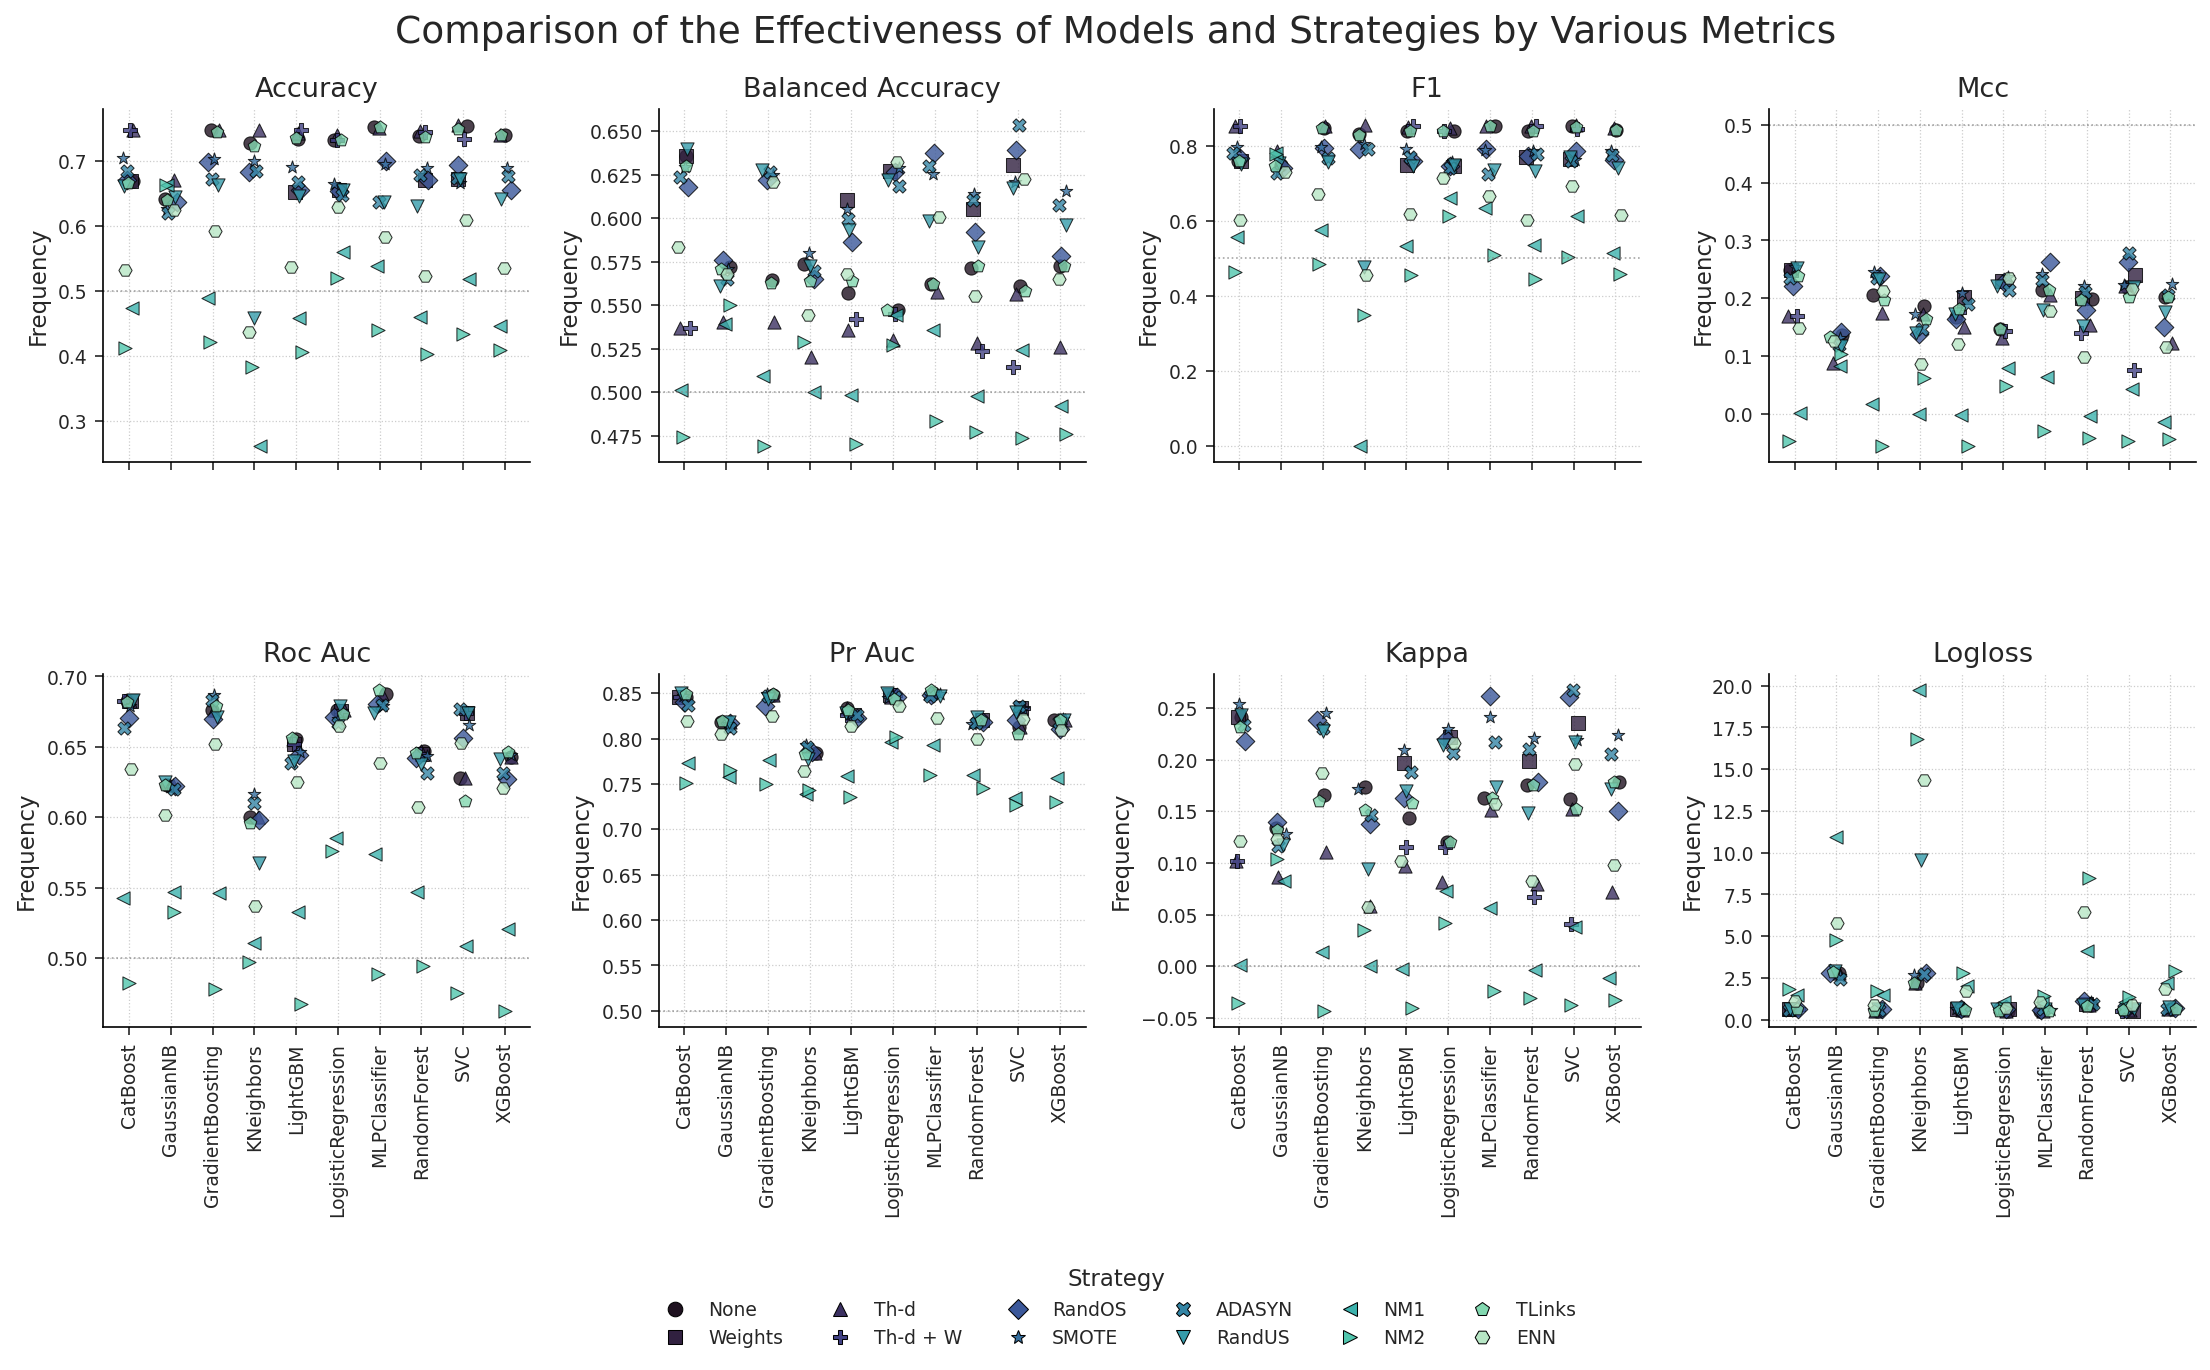

In [83]:
# %% [markdown]
# # Визуализация Сравнения Моделей и Стратегий в Стиле EDA (v2)
#
# Используем стиль и палитру, определенные ранее для EDA,
# чтобы визуализировать результаты сравнения всех моделей и стратегий
# по всем 8 метрикам в виде сетки графиков.

# %%
# ========= 9. Импорты и Переопределение Стиля =========
import matplotlib.pyplot as plt
import matplotlib.lines as mlines # Для создания ручной легенды
import seaborn as sns
import numpy as np
import pandas as pd
from math import ceil
import os # Если запускается отдельно от предыдущей ячейки

# --- Переопределение Настроек Стиля (из EDA v3 - unified theme) ---
plt.style.use('seaborn-v0_8-whitegrid') # Используем whitegrid для лучшей читаемости сетки

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.format': 'png',
    'savefig.bbox': 'tight',
    'axes.linewidth': 0.8,
    'axes.edgecolor': 'black',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'grid.color': '#cccccc', # Более светлая сетка
    'grid.linestyle': ':', # Точечная сетка
    'grid.linewidth': 0.6,
    # Убираем верхнюю и правую рамки для чистоты
    'axes.spines.top': False,
    'axes.spines.right': False
})

# --- Переопределение Цветовой Темы и Маркеров ---
# Проверяем наличие strategies, если нет, создаем пустой словарь
if 'strategies' not in locals(): strategies = {}
n_strategies = len(strategies)
if n_strategies == 0: print("ВНИМАНИЕ: Словарь 'strategies' пуст или не определен!")

palette_name = 'mako' # Та же палитра
strategy_colors = sns.color_palette(palette_name, n_colors=max(n_strategies, 1)) # Избегаем n_colors=0
markers = ['o', 's', '^', 'P', 'D', '*', 'X', 'v', '<', '>', 'p', 'H']
# Убедимся, что маркеров достаточно
if n_strategies > len(markers):
    markers = (markers * (n_strategies // len(markers) + 1))[:n_strategies]

strategy_color_map = {name: color for name, color in zip(strategies.keys(), strategy_colors)}
strategy_marker_map = {name: marker for name, marker in zip(strategies.keys(), markers)}
contour_color = 'black'
point_contour_lw = 0.5

# Убедимся, что DataFrame comparison_df существует
if 'comparison_df' not in locals():
    print("DataFrame 'comparison_df' не найден. Запустите ячейку с экспериментом сначала.")
    if 'all_results' in locals():
         all_results_list = []
         for model_name, df_result in all_results.items():
            # Убедимся, что метрики являются колонками перед reset_index
            if isinstance(df_result.index, pd.MultiIndex):
                df_result = df_result.reset_index() # Может не сработать если индекс не стандартный
            elif df_result.index.name != 'Strategy':
                 df_result = df_result.reset_index().rename(columns={'index': 'Strategy'})

            if 'Strategy' not in df_result.columns:
                 print(f"Пропускаем {model_name}, не удалось найти колонку 'Strategy' после reset_index")
                 continue

            df_result['Model'] = model_name
            all_results_list.append(df_result)

         if not all_results_list:
              raise NameError("Не удалось собрать данные из 'all_results'.")

         comparison_df = pd.concat(all_results_list, ignore_index=True)
         # Определяем порядок метрик снова, если он потерялся
         metric_order = ['accuracy', 'balanced_accuracy', 'kappa', 'f1', 'mcc', 'logloss', 'roc_auc', 'pr_auc']
         comparison_df = comparison_df.dropna(how='all', subset=[m for m in metric_order if m in comparison_df.columns])
         print("DataFrame 'comparison_df' создан из 'all_results'.")
    else:
        raise NameError("Переменные 'comparison_df' и 'all_results' не определены.")


# ========= Создание Фасетного Графика v2 (Scatterplot) =========

metric_order_display = ['accuracy', 'balanced_accuracy', 'f1', 'mcc',
                       'roc_auc', 'pr_auc', 'kappa', 'logloss']
n_metrics = len(metric_order_display)
n_cols = 4
n_rows = ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 4 + 1), # +1 для легенды
                         sharex=True, sharey=False) # Y-оси разные для разных метрик
axes = axes.flatten()

# Определяем порядок моделей на оси X
if 'Model' in comparison_df.columns:
     model_order = sorted(comparison_df['Model'].unique()) # Сортируем для консистентности
     model_positions = {model: i for i, model in enumerate(model_order)}
     # Используем числовые позиции для scatter plot
     comparison_df['Model_Pos'] = comparison_df['Model'].map(model_positions)
else:
     raise ValueError("Колонка 'Model' отсутствует в comparison_df")

# Определяем порядок стратегий для легенды
strategy_order_list = list(strategies.keys())

# Итерация по метрикам
for i, metric in enumerate(metric_order_display):
    ax = axes[i]
    if metric not in comparison_df.columns:
        ax.text(0.5, 0.5, f"Метрика '{metric}'\nне найдена", ha='center', va='center', fontsize=10, color='red')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    # Итерация по стратегиям для отрисовки точек с разными маркерами
    for strategy_name in strategy_order_list:
        # Фильтруем данные для текущей стратегии
        df_strat = comparison_df[comparison_df['Strategy'] == strategy_name]
        if df_strat.empty: continue # Пропускаем, если для стратегии нет данных

        color = strategy_color_map.get(strategy_name, 'grey') # Цвет
        marker = strategy_marker_map.get(strategy_name, 'o') # Маркер

        # Добавляем небольшой случайный сдвиг для лучшей видимости
        jitter_amount = 0.15 # Величина разброса
        x_jittered = df_strat['Model_Pos'] + np.random.uniform(-jitter_amount, jitter_amount, size=len(df_strat))

        # Рисуем scatter plot для текущей стратегии
        ax.scatter(
            x=x_jittered,
            y=df_strat[metric],
            color=color,
            marker=marker,
            edgecolor=contour_color,
            linewidth=point_contour_lw,
            alpha=0.8,
            s=40, # Размер маркера
            label=strategy_name # Добавляем label только один раз для легенды (сделаем вручную)
        )

    # Настройка подграфика
    ax.set_title(metric.replace("_"," ").title())
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    ax.grid(True) # Сетка включена и настроена через rcParams

    # Устанавливаем тики и метки оси X только для нижних графиков
    if i >= n_metrics - n_cols: # Если это нижний ряд
         ax.set_xticks(list(model_positions.values()))
         ax.set_xticklabels(model_order, rotation=90)
    else:
         ax.set_xticks([]) # Убираем тики у верхних

    # Добавляем горизонтальную линию (где уместно)
    if metric not in ['logloss', 'kappa']:
         ax.axhline(0.5, color='grey', linestyle=':', linewidth=0.8, alpha=0.7)
    elif metric == 'kappa':
         ax.axhline(0.0, color='grey', linestyle=':', linewidth=0.8, alpha=0.7)

# Убираем лишние оси
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ========= Создание Общей Легенды (как раньше) =========
handles = []
labels = []
# Проверяем, что словари не пустые
if strategy_color_map and strategy_marker_map:
    for strategy in strategy_order_list:
        # Убедимся, что стратегия есть в картах
        if strategy in strategy_color_map and strategy in strategy_marker_map:
            handle = mlines.Line2D([], [], color=strategy_color_map[strategy], # Используем цвет фона для линии
                                    marker=strategy_marker_map[strategy],
                                    linestyle='None', # Без линии
                                    markersize=7,
                                    markeredgecolor=contour_color,
                                    markeredgewidth=point_contour_lw,
                                    label=strategy) # Label для текста
            handles.append(handle)
            labels.append(strategy)
        else:
             print(f"Пропускаем стратегию '{strategy}' в легенде (нет цвета/маркера)")

    # Размещаем легенду под графиками
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0),# Располагаем ниже
               ncol=min(6, n_strategies) if n_strategies > 0 else 1,
               title="Strategy", title_fontsize=11)
else:
     print("Не удалось создать легенду: карты цветов/маркеров пусты.")


# ========= Финальная Настройка и Сохранение =========
fig.suptitle('Comparison of the Effectiveness of Models and Strategies by Various Metrics', fontsize=18, y=1.0) # Уменьшил y
plt.subplots_adjust(bottom=0.25, top=0.93, hspace=0.6, wspace=0.3) # Увеличил hspace, уменьшил top

plt.savefig('full_comparison_faceted_plot_v2_eda_style.png', dpi=300)
print("\nФасетный график сохранен как 'full_comparison_faceted_plot_v2_eda_style.png'")

plt.show()


--- Генерация графика для модели: MLPClassifier ---
График сохранен как 'strategies_barplot_MLPClassifier.png'


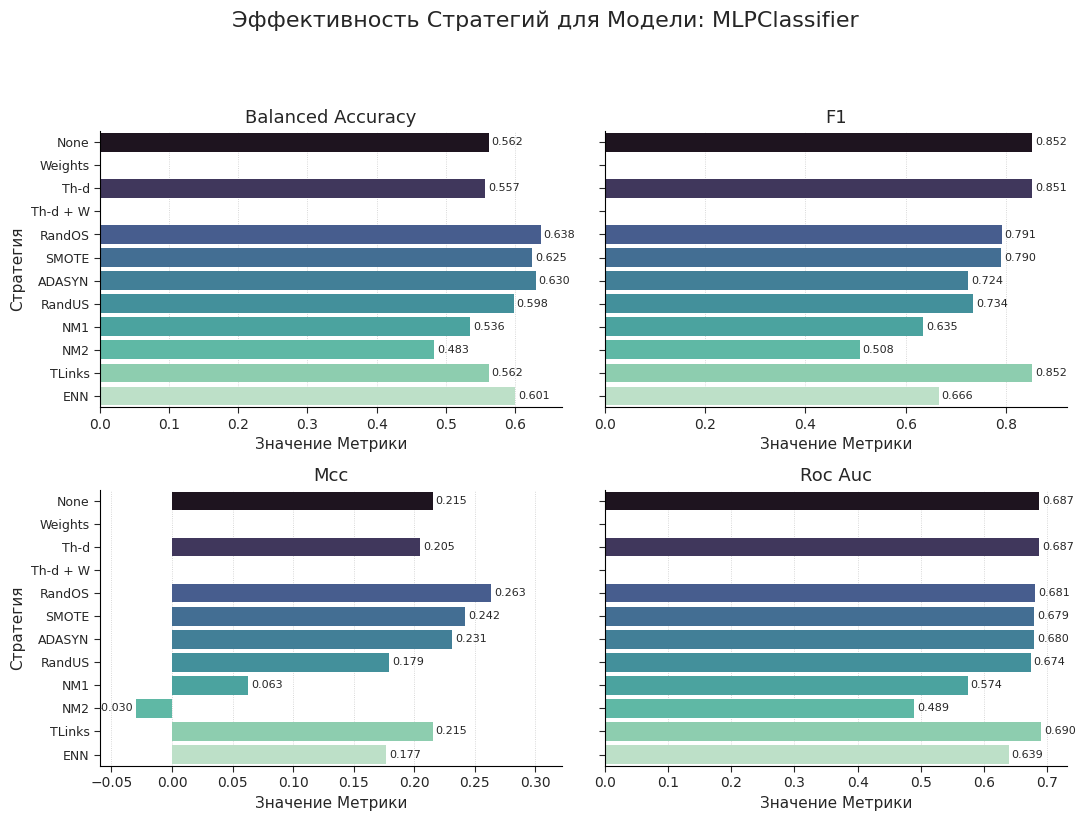


--- Генерация графика для модели: RandomForest ---
График сохранен как 'strategies_barplot_RandomForest.png'


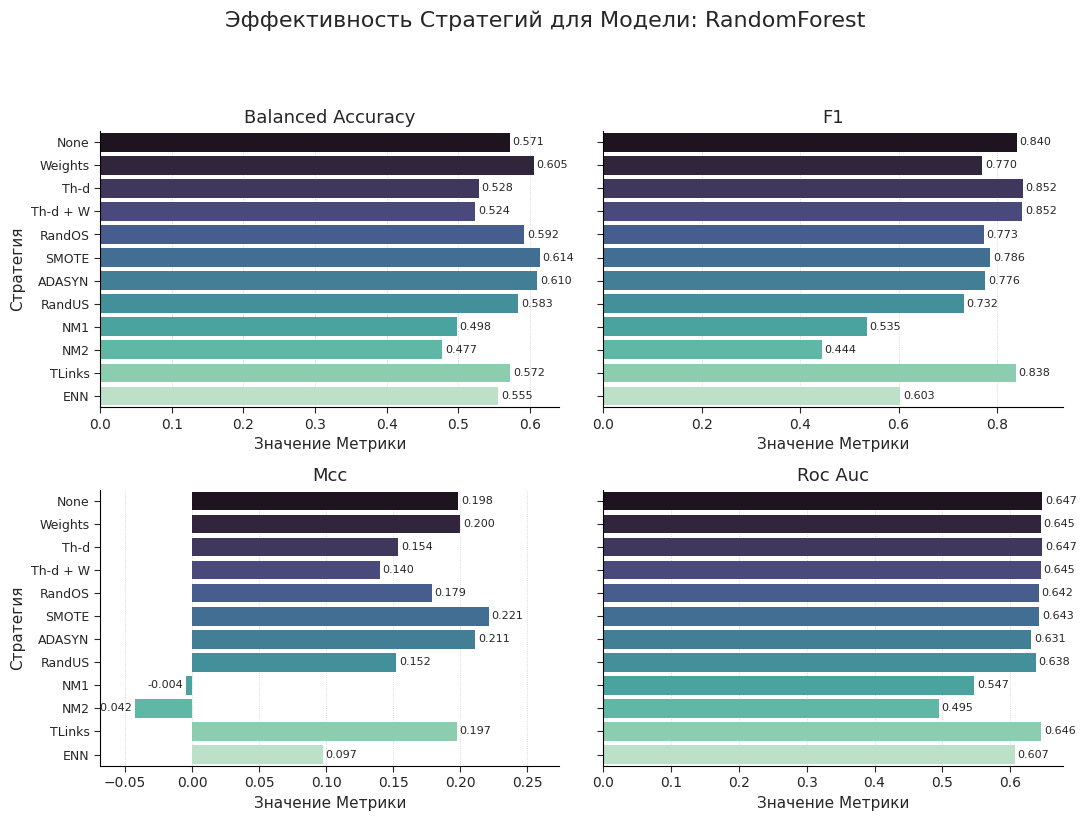


--- Генерация графика для модели: CatBoost ---
График сохранен как 'strategies_barplot_CatBoost.png'


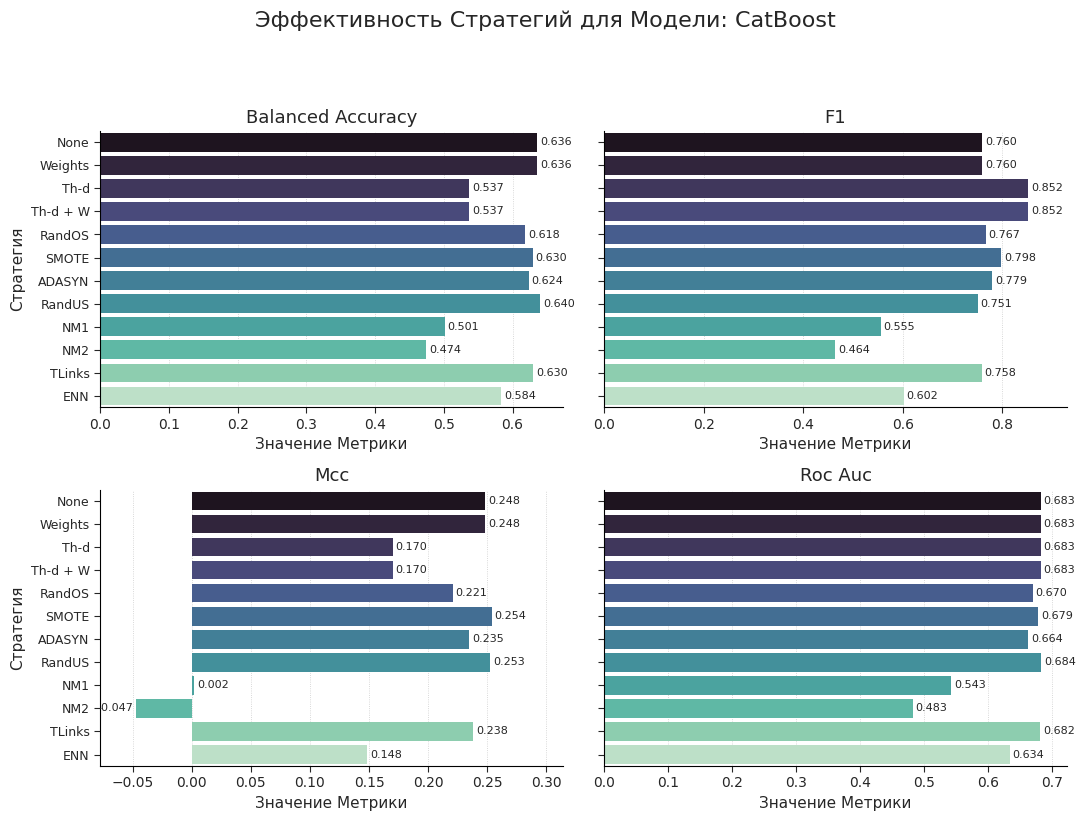


--- Генерация графика для модели: LightGBM ---
График сохранен как 'strategies_barplot_LightGBM.png'


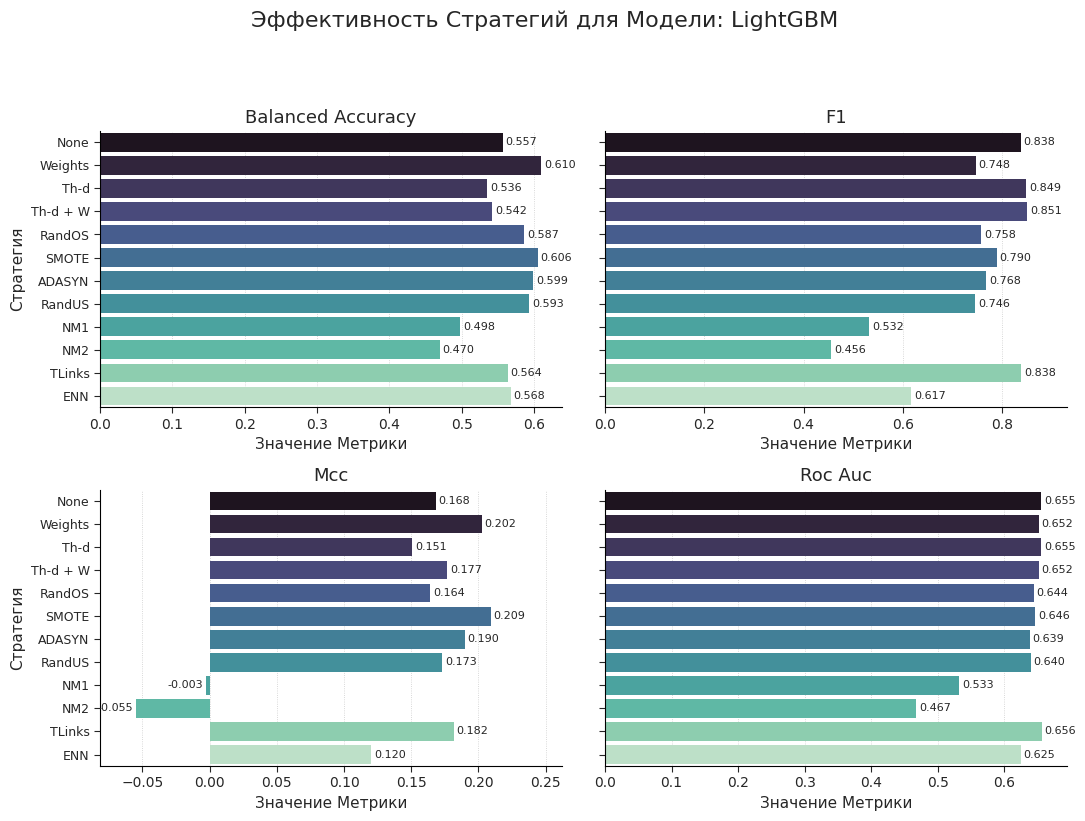


--- Генерация графика сравнения моделей для метрики: balanced_accuracy ---
График сохранен как 'models_barplot_balanced_accuracy.png'


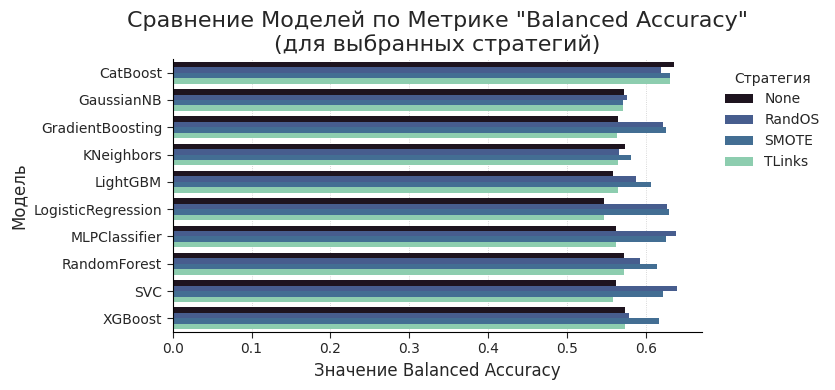

In [74]:
# %% [markdown]
# # Визуализация Результатов Сравнения с Помощью Barplot
#
# Создадим несколько графиков для более детального анализа:
# 1. Сравнение эффективности стратегий для нескольких выбранных моделей.
# 2. Сравнение эффективности моделей для нескольких выбранных стратегий.

# %%
# ========= 10. Импорты и Настройки Стиля (Повторно, для надежности) =========
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import ceil
import os

# --- Настройки Стиля (из EDA v3 - unified theme) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif', 'font.size': 10, 'axes.labelsize': 11,
    'axes.titlesize': 13, 'xtick.labelsize': 10, 'ytick.labelsize': 10, # Сделаем тики чуть крупнее
    'legend.fontsize': 10, 'figure.dpi': 100, 'savefig.dpi': 300,
    'savefig.format': 'png', 'savefig.bbox': 'tight', 'axes.linewidth': 0.8,
    'axes.edgecolor': 'black', 'xtick.major.size': 4, 'ytick.major.size': 4,
    'xtick.major.width': 0.8, 'ytick.major.width': 0.8, 'grid.color': '#cccccc',
    'grid.linestyle': ':', 'grid.linewidth': 0.6,
    'axes.spines.top': False, 'axes.spines.right': False
})

# --- Цветовая Тема и Порядки ---
# Используем 'mako' для стратегий, 'viridis' для моделей (или наоборот)
if 'strategies' not in locals(): strategies = {}
n_strategies = len(strategies)
if n_strategies == 0: print("ВНИМАНИЕ: Словарь 'strategies' пуст!")
palette_name_strat = 'mako'
strategy_colors = sns.color_palette(palette_name_strat, n_colors=max(n_strategies, 1))
strategy_color_map = {name: color for name, color in zip(strategies.keys(), strategy_colors)}
strategy_order_list = list(strategies.keys()) # Порядок для оси Y

# Убедимся, что DataFrame comparison_df и model_order существуют
if 'comparison_df' not in locals(): raise NameError("'comparison_df' не определен.")
if 'model_order' not in locals(): model_order = sorted(comparison_df['Model'].unique())

# ========= 11. Визуализация 1: Стратегии для Ключевых Моделей =========

models_to_plot = ['MLPClassifier', 'RandomForest', 'CatBoost', 'LightGBM'] # Выберите модели
metrics_to_plot = ['balanced_accuracy', 'f1', 'mcc', 'roc_auc'] # Выберите метрики
n_metrics_plot = len(metrics_to_plot)
n_cols_met = 2 # 2 метрики в ряд
n_rows_met = ceil(n_metrics_plot / n_cols_met)

for model_name in models_to_plot:
    if model_name not in comparison_df['Model'].unique():
        print(f"Модель '{model_name}' не найдена в результатах, пропускаем.")
        continue

    # Фильтруем данные для текущей модели
    df_model = comparison_df[comparison_df['Model'] == model_name].copy()
    # Упорядочиваем стратегии
    df_model['Strategy'] = pd.Categorical(df_model['Strategy'], categories=strategy_order_list, ordered=True)
    df_model = df_model.sort_values('Strategy')

    fig, axes = plt.subplots(n_rows_met, n_cols_met, figsize=(n_cols_met * 5.5, n_rows_met * 4), sharey=True)
    axes = axes.flatten()

    print(f"\n--- Генерация графика для модели: {model_name} ---")

    for i, metric in enumerate(metrics_to_plot):
        if metric not in df_model.columns: continue
        ax = axes[i]
        sns.barplot(
            data=df_model,
            y='Strategy', # Стратегии на оси Y (горизонтальные бары)
            x=metric,
            palette=strategy_color_map, # Раскрашиваем бары по стратегии
            hue='Strategy', # Используем hue для присвоения цветов из палитры
            order=strategy_order_list, # Порядок стратегий
            dodge=False, # Не группируем, т.к. hue=y
            ax=ax,
            legend=False # Убираем авто-легенду
        )
        ax.set_title(metric.replace("_"," ").title())
        ax.set_xlabel('Значение Метрики')
        ax.set_ylabel('Стратегия' if i % n_cols_met == 0 else '') # Подпись Y только у левых графиков
        ax.tick_params(axis='y', labelsize=9) # Метки стратегий могут быть длинными

        # Добавляем значения на бары
        for C in ax.containers:
             ax.bar_label(C, fmt='%.3f', label_type='edge', padding=2, fontsize=8)

        # Настройка пределов X для лучшего вида
        min_val = df_model[metric].min()
        max_val = df_model[metric].max()
        padding = (max_val - min_val) * 0.1 # 10% от диапазона
        ax.set_xlim(left=min(0, min_val - padding), right=max_val + padding * 2) # Добавляем больше места справа для текста


    # Удаляем пустые сабплоты
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Эффективность Стратегий для Модели: {model_name}', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Оставляем место для заголовка

    # Сохраняем график
    filename = f'strategies_barplot_{model_name}.png'
    plt.savefig(filename, dpi=300)
    print(f"График сохранен как '{filename}'")
    plt.show()


# ========= 12. Визуализация 2: Модели для Ключевых Стратегий =========

strategies_to_plot = ['None', 'RandOS', 'SMOTE', 'TLinks'] # Выберите стратегии
# Используем только одну ключевую метрику для сравнения моделей
metric_for_model_comp = 'balanced_accuracy'

df_strategies = comparison_df[comparison_df['Strategy'].isin(strategies_to_plot)].copy()

if df_strategies.empty:
     print("\nНе найдены данные для выбранных стратегий для Визуализации 2.")
else:
    print(f"\n--- Генерация графика сравнения моделей для метрики: {metric_for_model_comp} ---")
    plt.figure(figsize=(10, len(model_order) * 0.4)) # Динамическая высота

    sns.barplot(
        data=df_strategies,
        y='Model',
        x=metric_for_model_comp,
        hue='Strategy', # Группируем по стратегии
        order=sorted(df_strategies['Model'].unique()), # Упорядочим модели по алфавиту
        hue_order=[s for s in strategies_to_plot if s in df_strategies['Strategy'].unique()], # Порядок стратегий
        palette=[strategy_color_map.get(s,'grey') for s in strategies_to_plot], # Цвета стратегий
        orient='h' # Горизонтальная ориентация
    )

    plt.title(f'Сравнение Моделей по Метрике "{metric_for_model_comp.replace("_"," ").title()}"\n(для выбранных стратегий)', fontsize=16)
    plt.xlabel(f'Значение {metric_for_model_comp.replace("_"," ").title()}', fontsize=12)
    plt.ylabel('Модель', fontsize=12)
    plt.legend(title='Стратегия', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='x', linestyle=':', linewidth=0.6)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Оставляем место справа для легенды

    # Сохраняем график
    filename = f'models_barplot_{metric_for_model_comp}.png'
    plt.savefig(filename, dpi=300)
    print(f"График сохранен как '{filename}'")
    plt.show()


--- Generating plot for model: CatBoost ---
Plot saved as 'strategies_comparison_CatBoost.png'


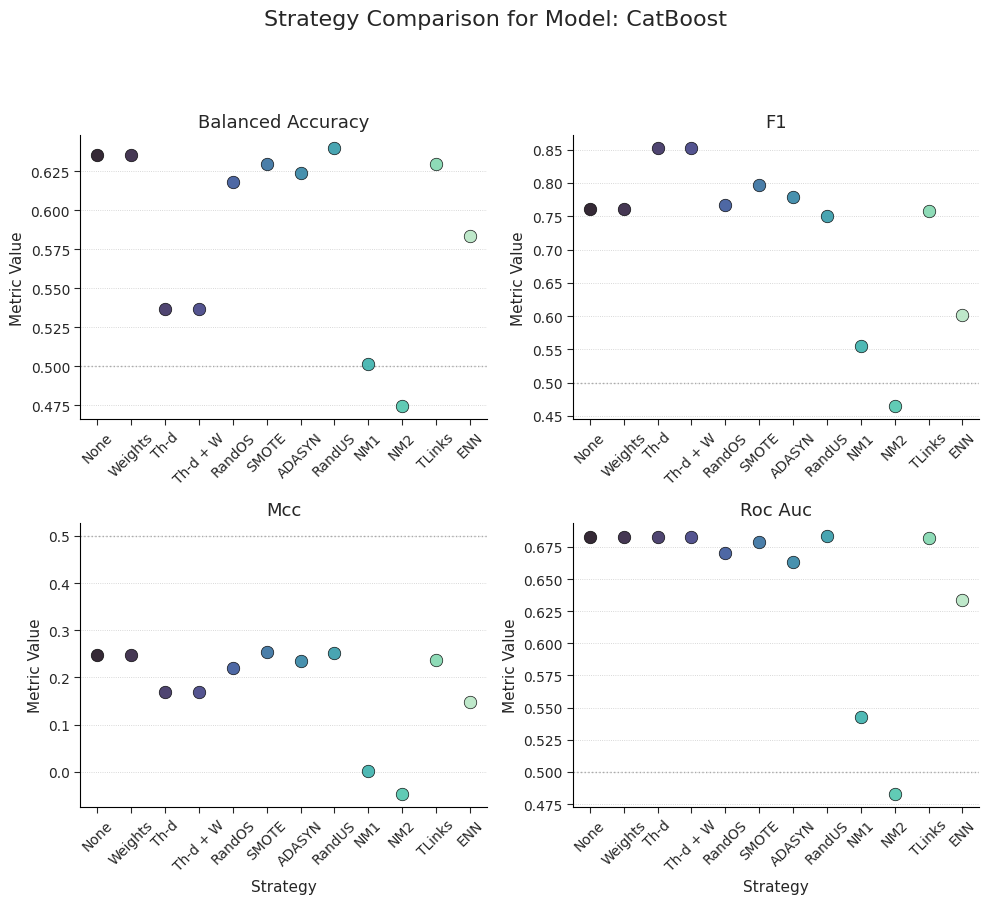


--- Generating plot for model: GaussianNB ---
Plot saved as 'strategies_comparison_GaussianNB.png'


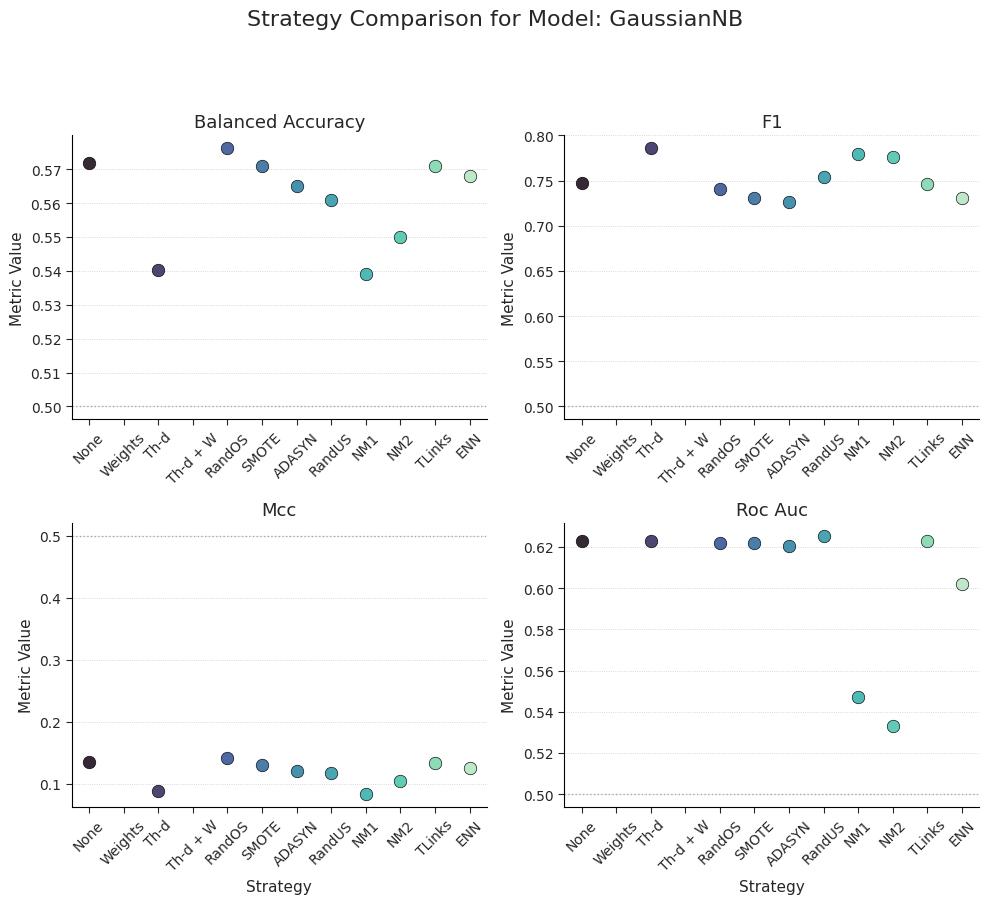


--- Generating plot for model: GradientBoosting ---
Plot saved as 'strategies_comparison_GradientBoosting.png'


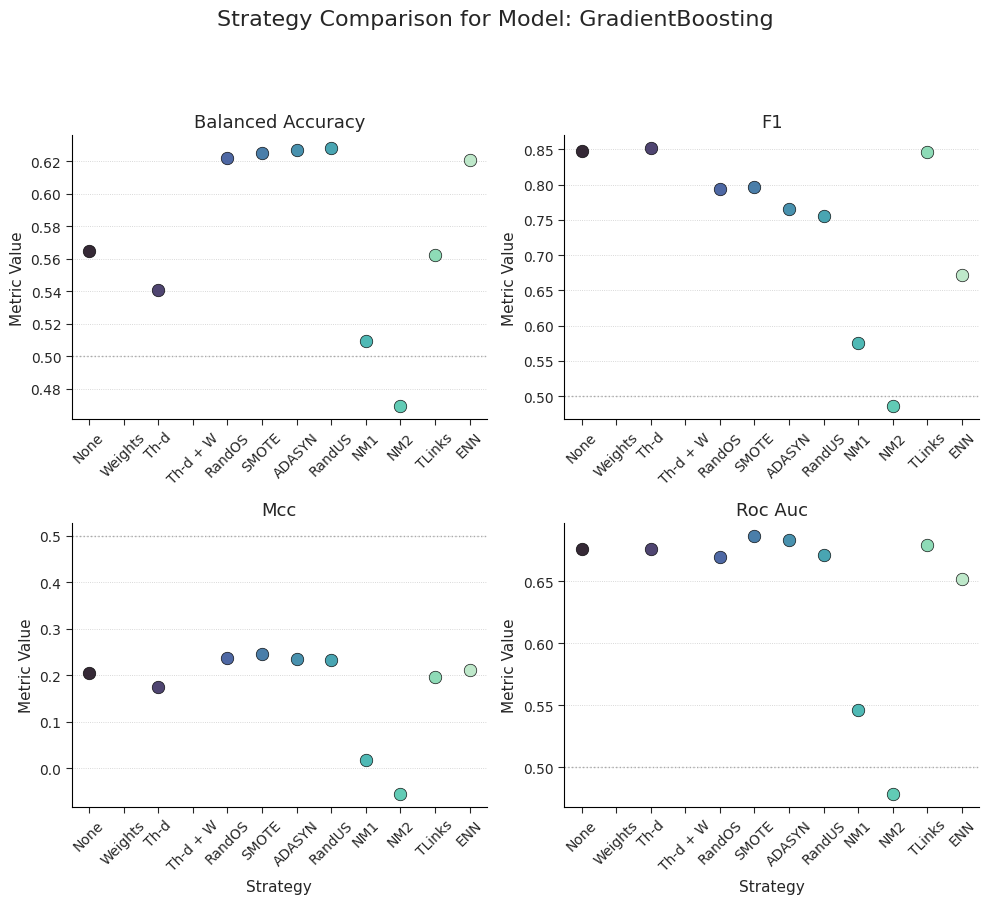


--- Generating plot for model: KNeighbors ---
Plot saved as 'strategies_comparison_KNeighbors.png'


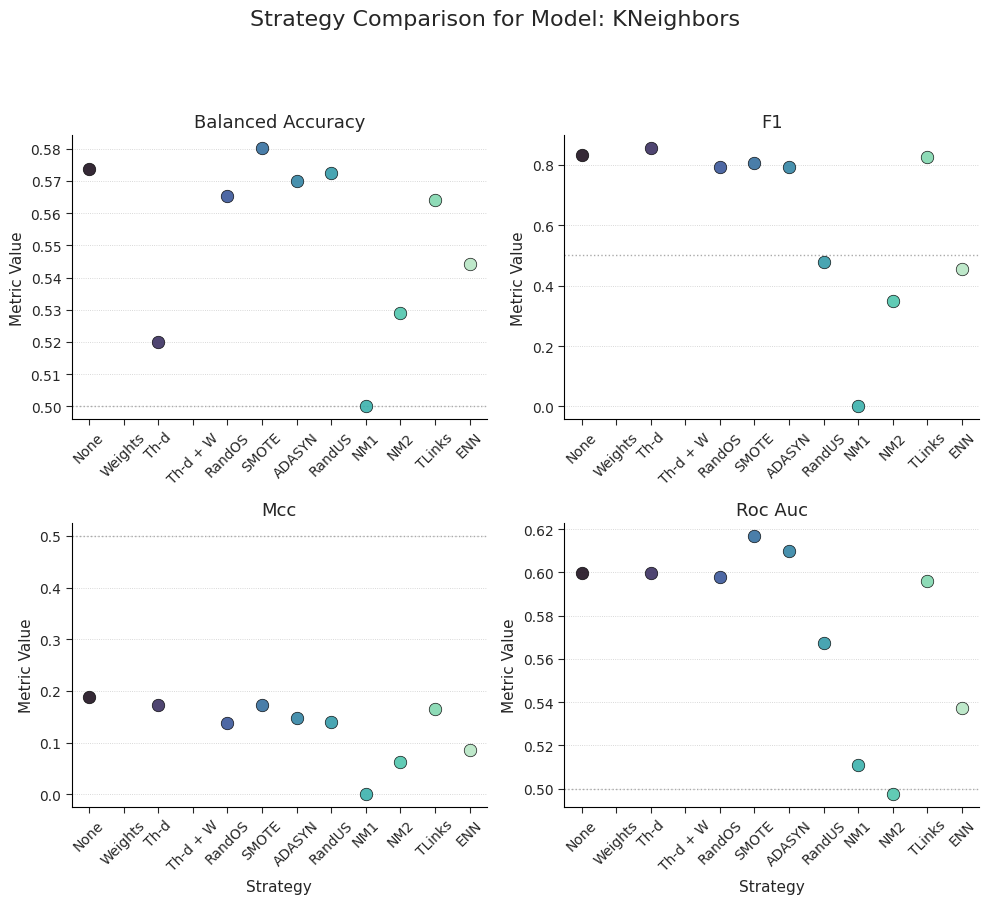


--- Generating plot for model: LightGBM ---
Plot saved as 'strategies_comparison_LightGBM.png'


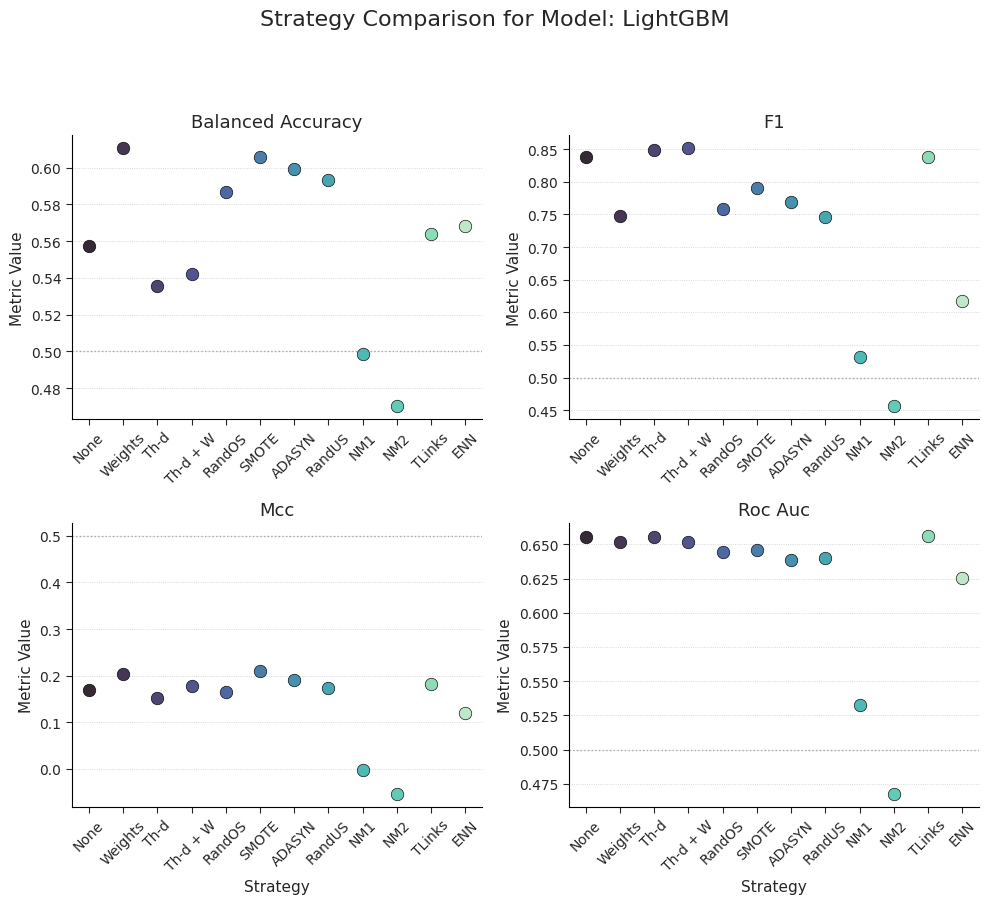


--- Generating plot for model: LogisticRegression ---
Plot saved as 'strategies_comparison_LogisticRegression.png'


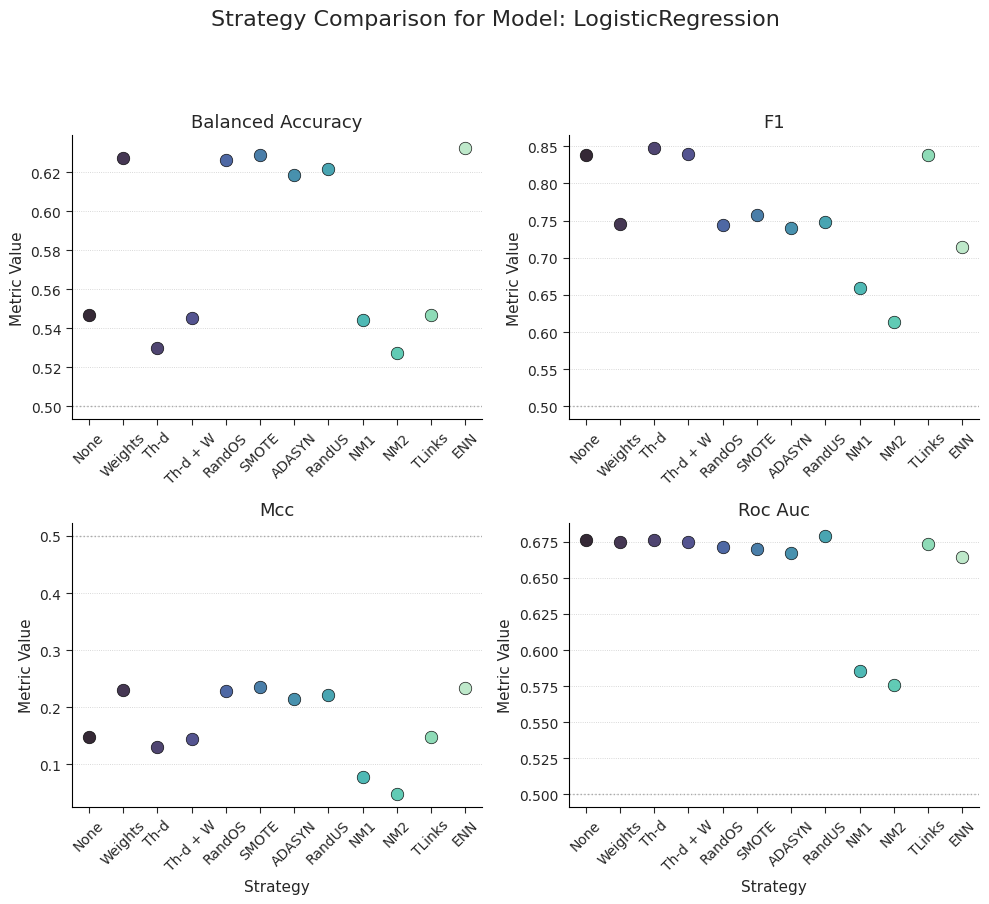


--- Generating plot for model: MLPClassifier ---
Plot saved as 'strategies_comparison_MLPClassifier.png'


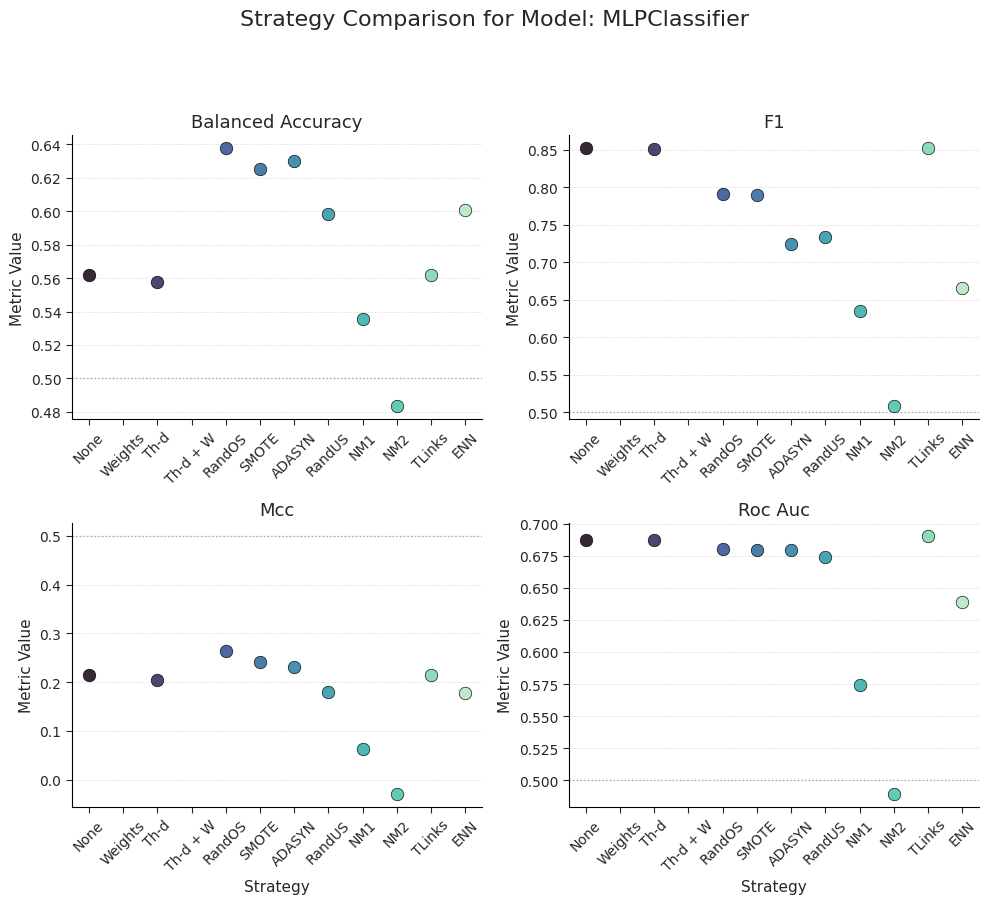


--- Generating plot for model: RandomForest ---
Plot saved as 'strategies_comparison_RandomForest.png'


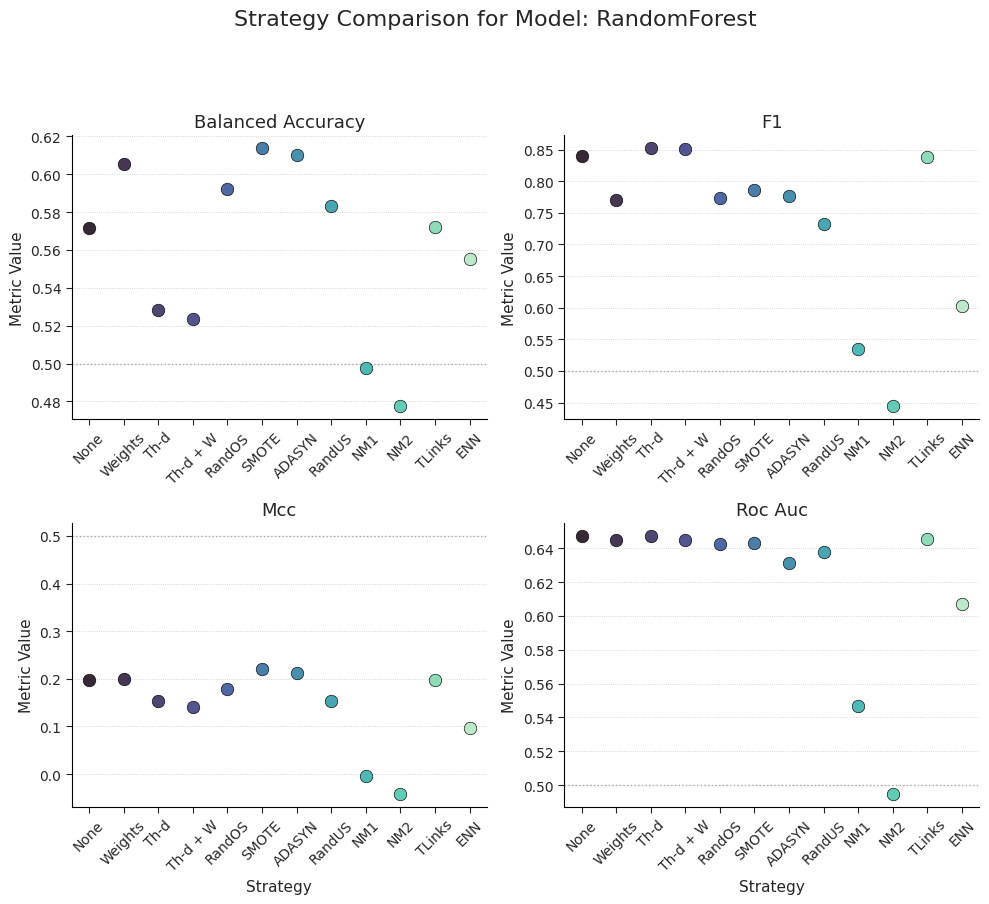


--- Generating plot for model: SVC ---
Plot saved as 'strategies_comparison_SVC.png'


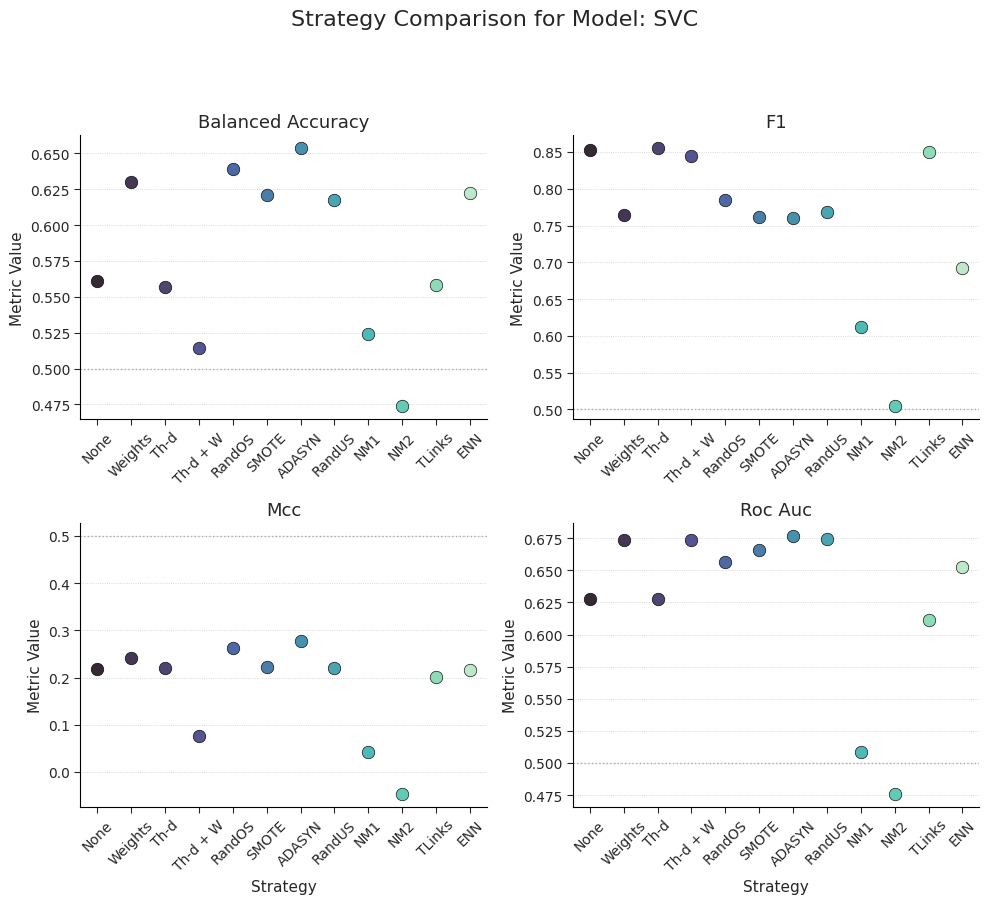


--- Generating plot for model: XGBoost ---
Plot saved as 'strategies_comparison_XGBoost.png'


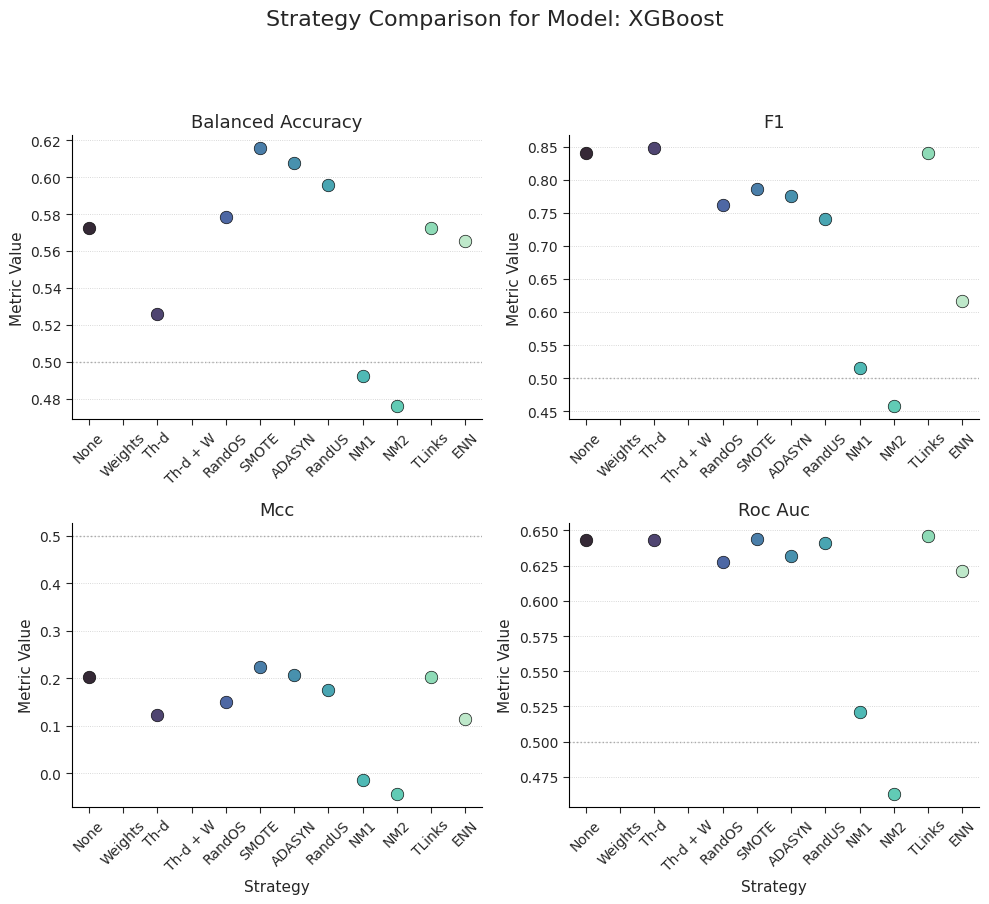

In [92]:
# %% [markdown]
# # Visualization of Comparison Results using Boxplot-like Plots
#
# Using stripplot to simulate the comparison of distributions (although we have 1 point per combo).
# This will show the metric values for different strategies within a single model.

# %%
# ========= 10. Imports and Style Settings (Reapplying for safety) =========
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import ceil
import os
import matplotlib.lines as mlines # For manual legend

# --- Style Settings (from EDA v3 - unified theme) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif', 'font.size': 10, 'axes.labelsize': 11,
    'axes.titlesize': 13, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'legend.fontsize': 10, 'figure.dpi': 100, 'savefig.dpi': 300,
    'savefig.format': 'png', 'savefig.bbox': 'tight', 'axes.linewidth': 0.8,
    'axes.edgecolor': 'black', 'xtick.major.size': 4, 'ytick.major.size': 4,
    'xtick.major.width': 0.8, 'ytick.major.width': 0.8, 'grid.color': '#cccccc',
    'grid.linestyle': ':', 'grid.linewidth': 0.6,
    'axes.spines.top': False, 'axes.spines.right': False
})

# --- Color Theme and Order ---
if 'strategies' not in locals(): strategies = {}
n_strategies = len(strategies)
if n_strategies == 0: print("WARNING: 'strategies' dictionary is empty or undefined!")
palette_name_strat = 'mako'
strategy_colors = sns.color_palette(palette_name_strat, n_colors=max(n_strategies, 1))
strategy_color_map = {name: color for name, color in zip(strategies.keys(), strategy_colors)}
strategy_order_list = list(strategies.keys()) # Order for Y-axis
contour_color = 'black'
point_contour_lw = 0.5

# Ensure comparison_df and model_order exist
if 'comparison_df' not in locals(): raise NameError("'comparison_df' is not defined.")
if 'model_order' not in locals(): model_order = sorted(comparison_df['Model'].unique())


# ========= 11. Visualization: Strategy Comparison per Key Model (Stripplot) =========

models_to_plot = sorted(comparison_df['Model'].unique())
metrics_to_plot = ['balanced_accuracy', 'f1', 'mcc', 'roc_auc'] # Select metrics
n_metrics_plot = len(metrics_to_plot)
n_cols_met = 2
n_rows_met = ceil(n_metrics_plot / n_cols_met)

for model_name in models_to_plot:
    if model_name not in comparison_df['Model'].unique():
        print(f"Model '{model_name}' not found in results, skipping.")
        continue

    df_model = comparison_df[comparison_df['Model'] == model_name].copy()
    df_model['Strategy'] = pd.Categorical(df_model['Strategy'], categories=strategy_order_list, ordered=True)
    df_model = df_model.sort_values('Strategy')

    fig, axes = plt.subplots(n_rows_met, n_cols_met, figsize=(n_cols_met * 5, n_rows_met * 4.5), sharey=False)
    axes = axes.flatten()

    print(f"\n--- Generating plot for model: {model_name} ---") # Removed (Stripplot) here too

    for i, metric in enumerate(metrics_to_plot):
        if metric not in df_model.columns: continue
        ax = axes[i]

        sns.stripplot(
            data=df_model,
            x='Strategy',
            y=metric,
            palette=strategy_color_map,
            hue='Strategy',
            order=strategy_order_list,
            marker='o',
            edgecolor=contour_color,
            linewidth=point_contour_lw,
            alpha=0.9,
            jitter=0.1,
            size=9,       # <--- Increased marker size
            ax=ax,
            legend=False
        )

        ax.set_title(metric.replace("_"," ").title())
        ax.set_ylabel('Metric Value')
        ax.set_xlabel('Strategy' if i >= n_metrics_plot - n_cols_met else '')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, axis='y', linestyle=':', linewidth=0.6)

        if metric not in ['logloss', 'kappa']: ax.axhline(0.5, color='#AAAAAA', linestyle=':', linewidth=1)
        elif metric == 'kappa': ax.axhline(0.0, color='#AAAAAA', linestyle=':', linewidth=1)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Updated Title
    fig.suptitle(f'Strategy Comparison for Model: {model_name}', fontsize=16, y=1.03) # Removed (Stripplot)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    filename = f'strategies_comparison_{model_name}.png' # Changed filename slightly
    plt.savefig(filename, dpi=300)
    print(f"Plot saved as '{filename}'")
    plt.show()


--- Generating heatmaps for metrics: ['balanced_accuracy', 'f1', 'mcc', 'roc_auc', 'pr_auc'] ---
  Generating heatmap for: balanced_accuracy
    Heatmap saved as 'heatmap_balanced_accuracy.png'


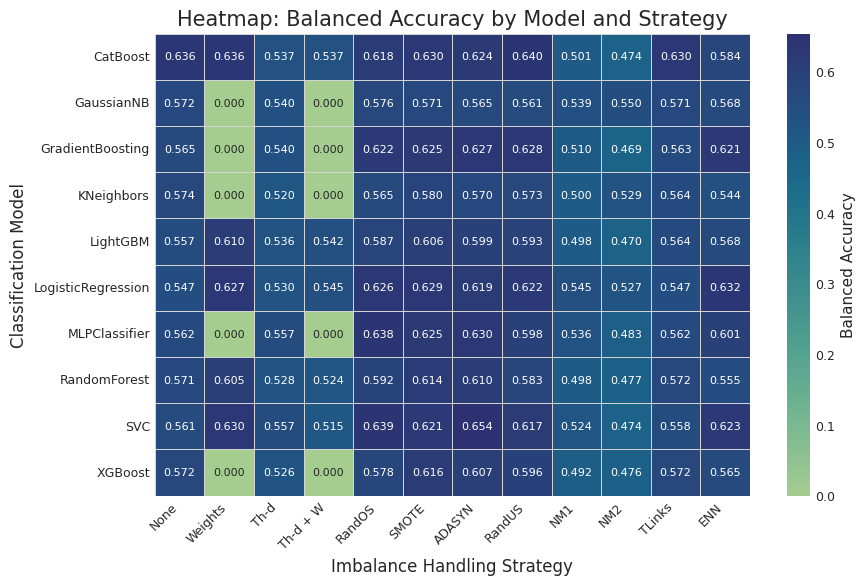

  Generating heatmap for: f1
    Heatmap saved as 'heatmap_f1.png'


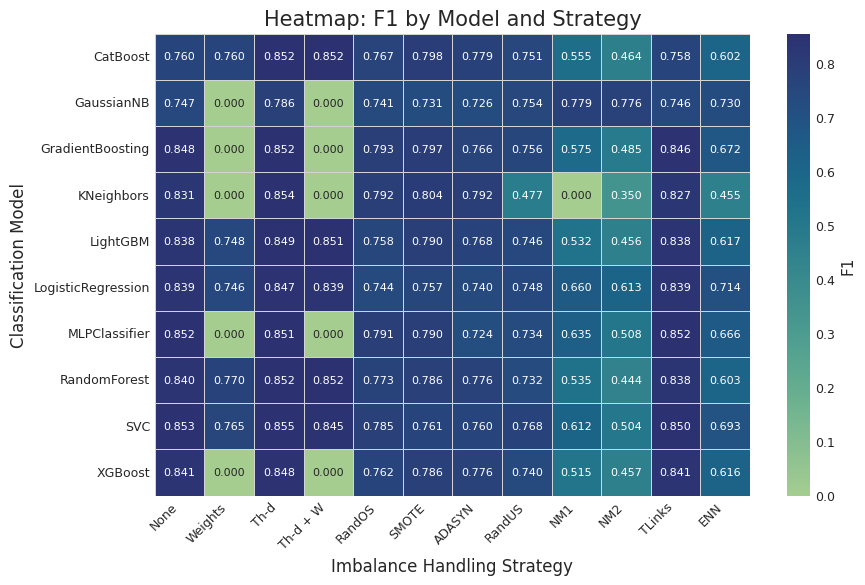

  Generating heatmap for: mcc
    Heatmap saved as 'heatmap_mcc.png'


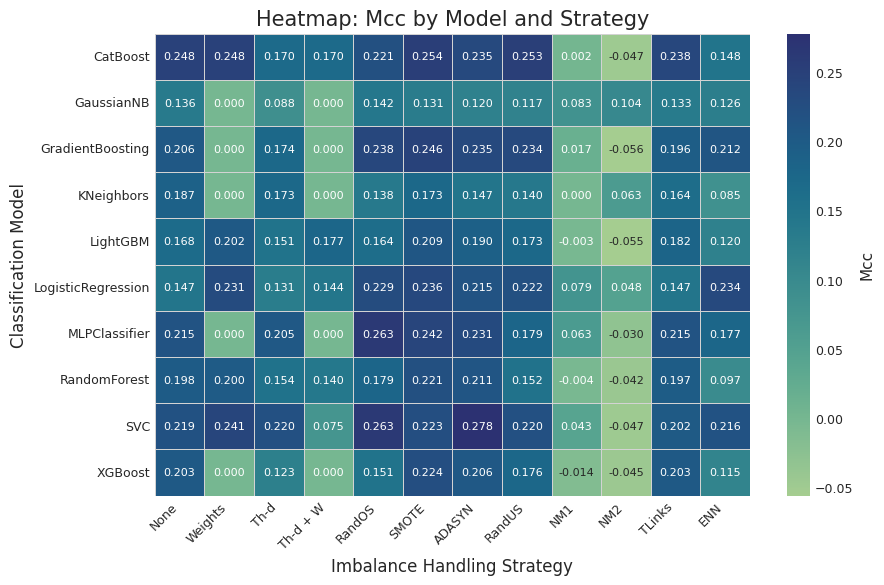

  Generating heatmap for: roc_auc
    Heatmap saved as 'heatmap_roc_auc.png'


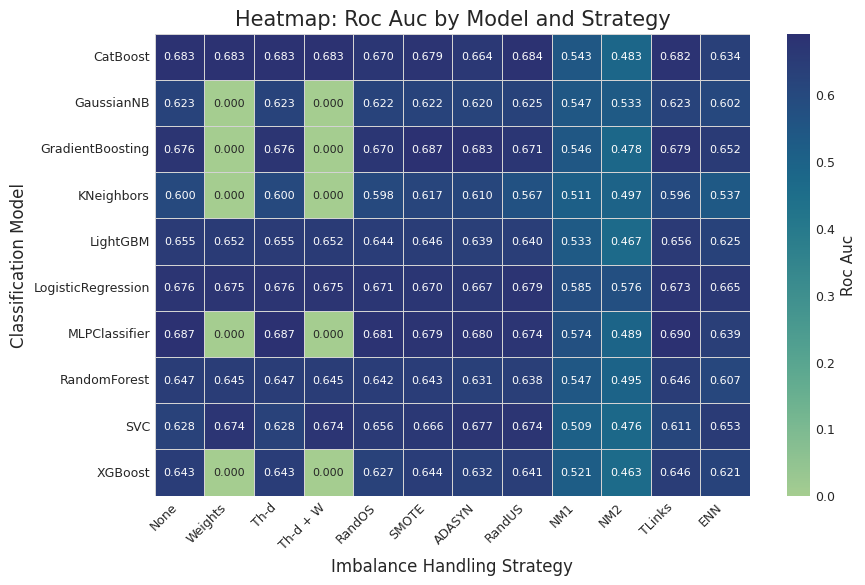

  Generating heatmap for: pr_auc
    Heatmap saved as 'heatmap_pr_auc.png'


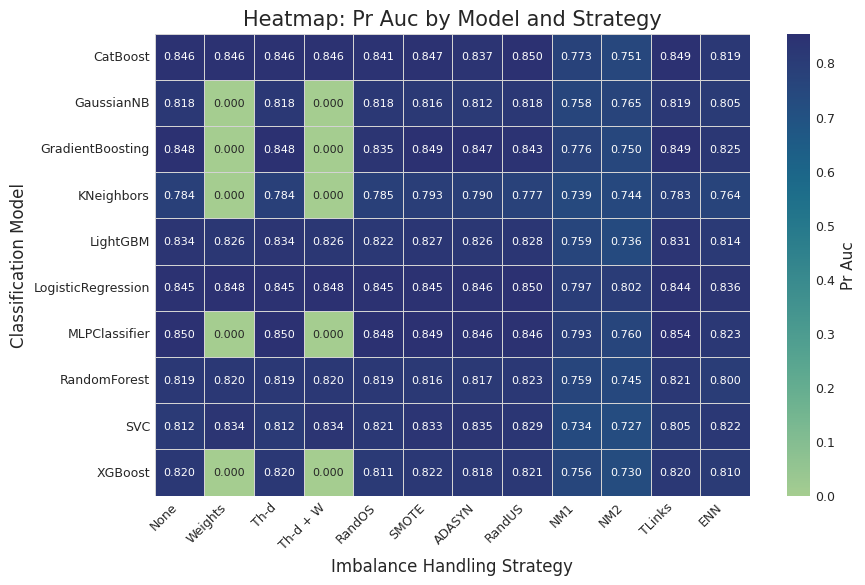


--- Heatmap generation complete ---


In [101]:
# %% [markdown]
# # Visualization of Results via Heatmaps
#
# Creating heatmaps for key metrics to visually compare the performance
# of all model and strategy combinations.
#
# **Metric Importance (for ddGPredictor task with imbalance):**
# - **Most Important:** MCC, Balanced Accuracy (reflect balanced performance).
# - **Also Important:** ROC AUC, PR AUC (show separability and focus on the positive class).
# - **Useful:** F1 (if precision/recall balance for the positive class is key), Kappa.
# - **Less Important (for *classification* quality):** LogLoss (evaluates probabilities), Accuracy (misleading).

# %%
# ========= 10. Imports and Style Settings (Reapplying) =========
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import ceil
import os

# --- Style Settings (from EDA v3 - unified theme) ---
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.family': 'sans-serif', 'font.size': 10, 'axes.labelsize': 11,
    'axes.titlesize': 14, 'xtick.labelsize': 9, 'ytick.labelsize': 9,
    'legend.fontsize': 10, 'figure.dpi': 100, 'savefig.dpi': 300,
    'savefig.format': 'png', 'savefig.bbox': 'tight', 'axes.linewidth': 0.8,
    'axes.edgecolor': 'black', 'xtick.major.size': 0, 'ytick.major.size': 0,
    'xtick.major.width': 0, 'ytick.major.width': 0,
})

# --- Color Theme ---
heatmap_cmap = 'crest' # Blue-green palette

# Ensure DataFrames and lists exist
if 'comparison_df' not in locals(): raise NameError("'comparison_df' is not defined.")
if 'strategies' not in locals(): strategies = {}
strategy_order_list = list(strategies.keys())
if 'model_order' not in locals(): model_order = sorted(comparison_df['Model'].unique())


# ========= 11. Creating Heatmaps for Key Metrics =========

metrics_for_heatmap = ['balanced_accuracy', 'f1', 'mcc', 'roc_auc', 'pr_auc'] # Key metrics

print(f"\n--- Generating heatmaps for metrics: {metrics_for_heatmap} ---")

for metric in metrics_for_heatmap:
    if metric not in comparison_df.columns:
        print(f"Metric '{metric}' not found in results, skipping.")
        continue

    print(f"  Generating heatmap for: {metric}")
    try:
        pivot_table = comparison_df.pivot(index='Model', columns='Strategy', values=metric)
        pivot_table = pivot_table.loc[model_order, [s for s in strategy_order_list if s in pivot_table.columns]]
        pivot_table = pivot_table.fillna(0) # Fill NaN for plotting
    except Exception as e:
        print(f"    Could not create pivot table for {metric}: {e}")
        continue

    figsize_h = max(6, len(pivot_table.index) * 0.5)
    figsize_w = max(8, len(pivot_table.columns) * 0.8)
    plt.figure(figsize=(figsize_w, figsize_h))

    # Create heatmap
    sns.heatmap(
        pivot_table,
        annot=True,           # Show values
        fmt=".3f",            # Value format
        cmap=heatmap_cmap,    # Color map
        linewidths=0.5,       # Lines between cells
        linecolor='lightgray',# Line color
        cbar=True,            # Show color bar
        cbar_kws={'label': f'{metric.replace("_"," ").title()}'}, # Color bar label (English)
        annot_kws={"size": 8} # Annotation font size
    )

    plt.title(f'Heatmap: {metric.replace("_"," ").title()} by Model and Strategy', fontsize=15) # English title
    plt.xlabel('Imbalance Handling Strategy', fontsize=12) # English X-label
    plt.ylabel('Classification Model', fontsize=12) # English Y-label
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Save the plot
    filename = f'heatmap_{metric}.png'
    plt.savefig(filename, dpi=300)
    print(f"    Heatmap saved as '{filename}'")
    plt.show() # Display the plot

print("\n--- Heatmap generation complete ---")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25296fc4-2e1a-40e5-990d-2e3a019f757c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>